# 0.0 IMPORTS

## packages

In [19]:
import os, pickle, datetime
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import scipy.stats as ss
import sweetviz as sv
import matplotlib.gridspec as gridspec



from sklearn.model_selection            import train_test_split
from sklearn.preprocessing              import RobustScaler,MinMaxScaler, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.base                       import BaseEstimator, TransformerMixin
from IPython.display                    import Image
from sklearn.linear_model               import LinearRegression, Lasso
from sklearn.ensemble                   import RandomForestRegressor
from boruta                             import BorutaPy


pd.options.display.max_columns = 500 # this will set limit of columns to 500
pd.set_option('display.float_format', lambda x: '%.5f' % x)

%matplotlib inline
os.getcwd()

'p:\\Python\\GitHub\\insurance_cross'

## helper classes

## helper funcions 

In [20]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [21]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [30, 16]
    plt.rcParams['font.size'] = 24
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## data import

In [22]:
df0=pd.read_csv(r"data/train.csv")
test=pd.read_csv(r"data/test.csv")
df0.head(1)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.00000,0,> 2 Years,Yes,40454.00000,26.00000,217,1


# split

In [93]:
X=df0.drop('Response',axis=1)
y=df0['Response']

Xtrain, Xtest0, ytrain, ytest0 = train_test_split(X,y, random_state=42,  test_size=0.40, stratify=y)

df0_train=pd.concat([Xtrain,ytrain],axis=1)

df0_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
215726,215727,Male,49,1,41.00000,0,1-2 Year,Yes,30123.00000,124.00000,109,0
244933,244934,Female,64,1,8.00000,0,1-2 Year,Yes,40700.00000,124.00000,241,0
189344,189345,Female,24,1,11.00000,1,< 1 Year,No,2630.00000,152.00000,120,0
232120,232121,Female,43,1,17.00000,1,1-2 Year,No,2630.00000,152.00000,159,0
304224,304225,Female,29,1,10.00000,1,< 1 Year,No,2630.00000,152.00000,117,0


# metadata

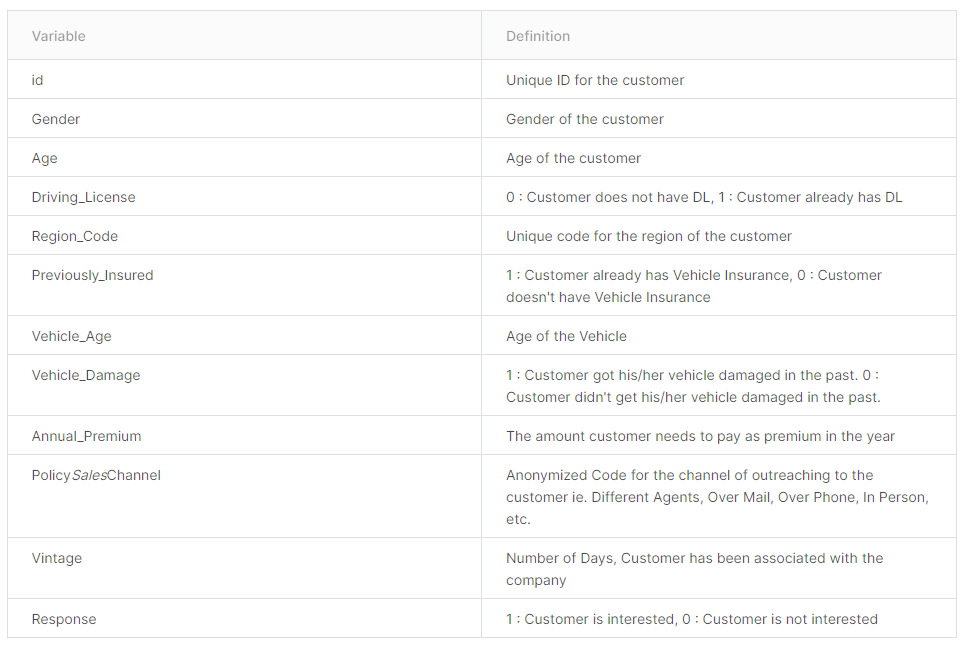

In [23]:
Image('img/metadata.png')

# 1.0 DATA DESCRIPTION

## 1.1 rename columns

In [62]:
df1=df0_train.copy()
df1.columns=df1.columns.str.lower()
df1.head(1)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
215726,215727,Male,49,1,41.00000,0,1-2 Year,Yes,30123.00000,124.00000,109,0


## 1.2 data dimensions

In [63]:
df1.shape

(228665, 12)

## 1.3 data types

In [64]:
df1.dtypes.sort_values()

id                        int64
age                       int64
driving_license           int64
previously_insured        int64
vintage                   int64
response                  int64
region_code             float64
annual_premium          float64
policy_sales_channel    float64
gender                   object
vehicle_age              object
vehicle_damage           object
dtype: object

In [65]:
#convert categoric features (region_code, policy_sales_channel) to object:
for i in ['region_code','policy_sales_channel']:
    df1[i]=df1[i].astype('object')

## 1.4 check NA

In [66]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 fillout NA

## 1.6 descriptive statistics for numeric attributes

In [67]:
num_cols=df1.select_dtypes(include=['int64','float64'])
num_cols.agg(["mean","median","std","min","max","skew","kurtosis"]).T

,mean,median,std,min,max,skew,kurtosis
id,190732.11463,190816.00000,110006.93804,2.00000,381109.00000,-0.00135,-1.19938
age,38.85382,36.00000,15.51915,20.00000,85.00000,0.66815,-0.57301
driving_license,0.99782,1.00000,0.04662,0.00000,1.00000,-21.35825,454.17881
previously_insured,0.45828,0.00000,0.49826,0.00000,1.00000,0.16748,-1.97197
annual_premium,30594.86624,31705.00000,17194.63877,2630.00000,508073.00000,1.49963,25.58896
vintage,154.44938,154.00000,83.65082,10.00000,299.00000,0.00234,-1.20027
response,0.12256,0.00000,0.32794,0.00000,1.00000,2.30191,3.29881


# 2.0 FEATURE ENGINEERING

## 2.1 hypotesis mapping

In [68]:
df2=df1.copy()

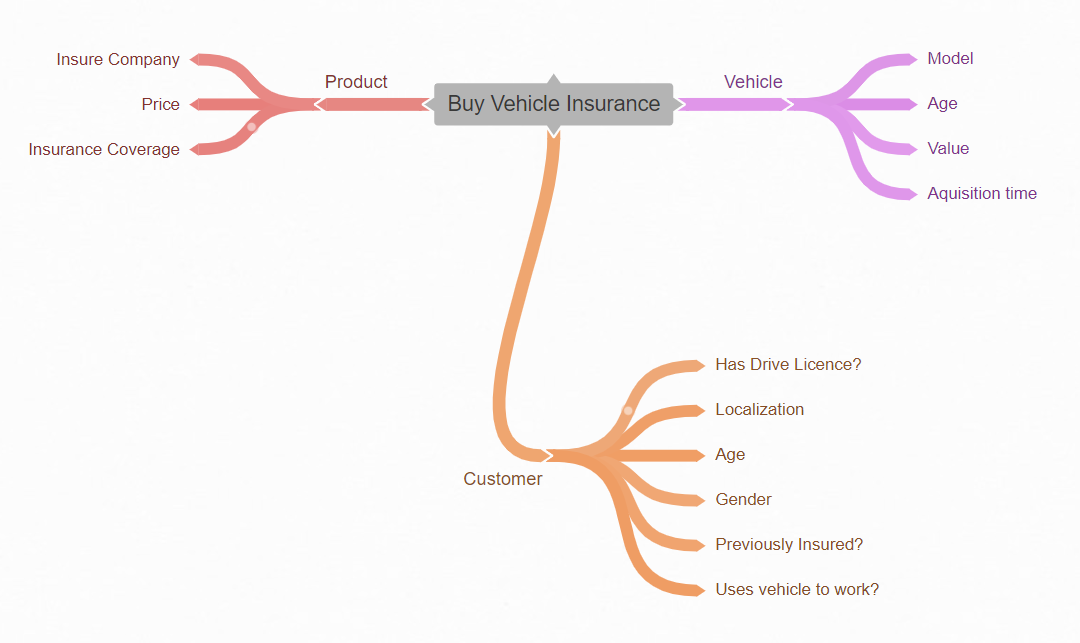

In [69]:
Image('img/mindmap.png')

## 2.2 hypotesis list

## 2.3 feature creation

## 2.4 rename object values: vehicle age

In [70]:
df2['vehicle_age'].unique()

array(['1-2 Year', '< 1 Year', '> 2 Years'], dtype=object)

In [71]:
df2['vehicle_age']=df2['vehicle_age'].map({'> 2 Years':'2. 2_more_years','1-2 Year':'1. 1_2_years', '< 1 Year': '0. 1_less_years'})
print(df2['vehicle_age'].unique())
df2.head(1)

['1. 1_2_years' '0. 1_less_years' '2. 2_more_years']


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
215726,215727,Male,49,1,41.00000,0,1. 1_2_years,Yes,30123.00000,124.00000,109,0


# 3.0 FEATURE FILTERING

In [72]:
df3=df2.copy()

## 3.1 row filtering

## 3.2 cols filtering

# 4.0 EXPLORATORY DATA ANALYSIS

In [73]:
df4=df3.copy()

## 4.1 univariate analysis

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report descritive analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



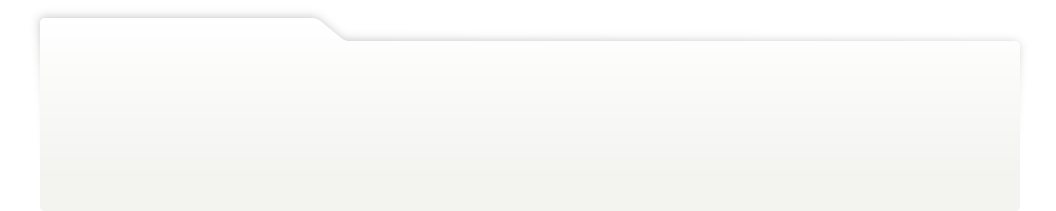
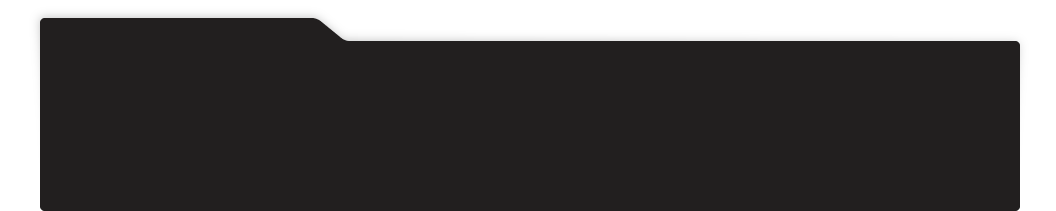
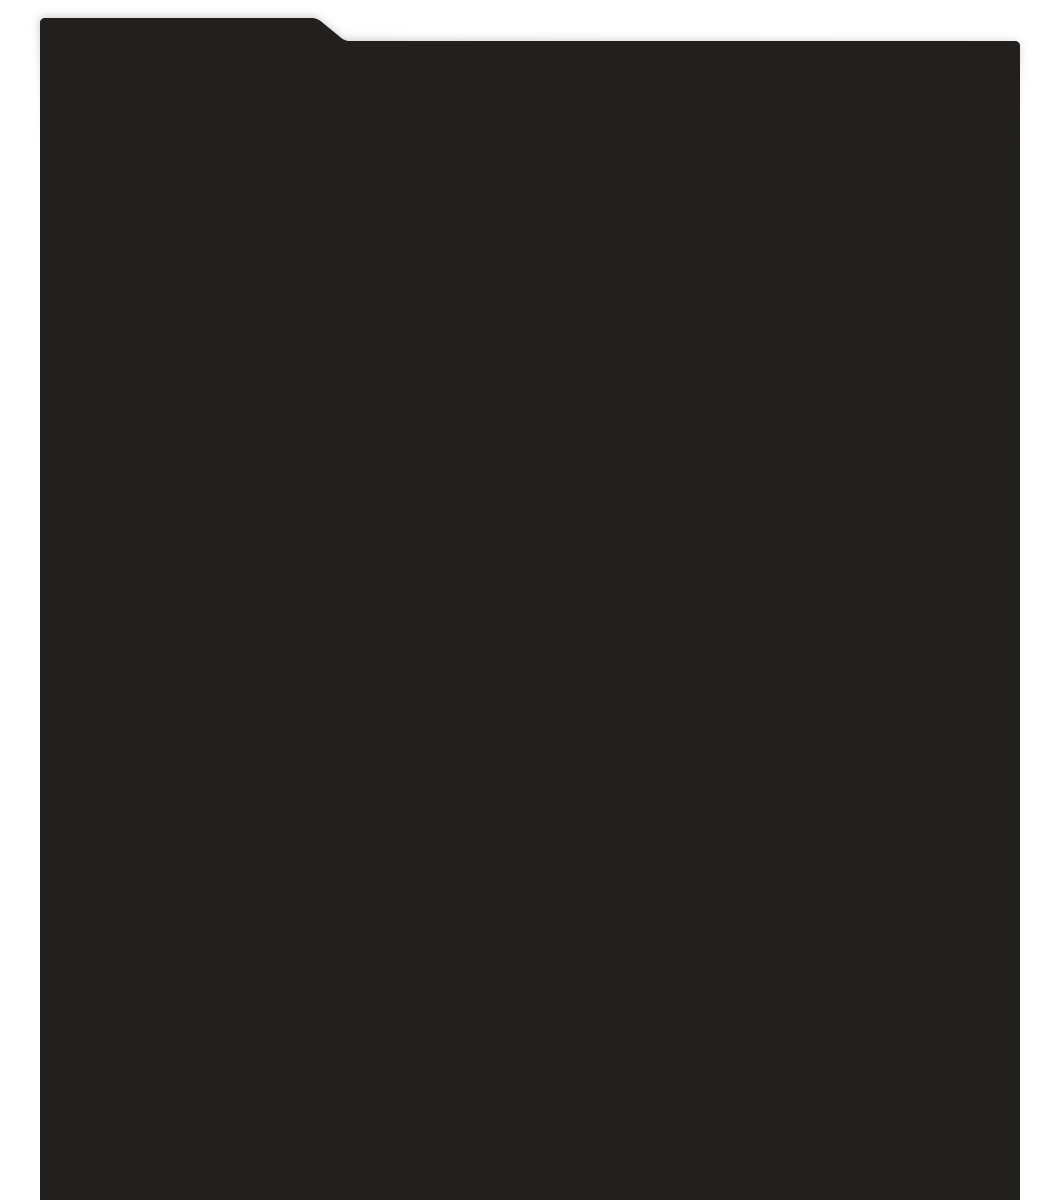
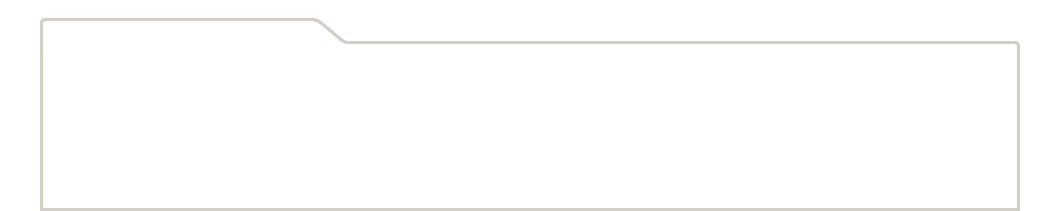
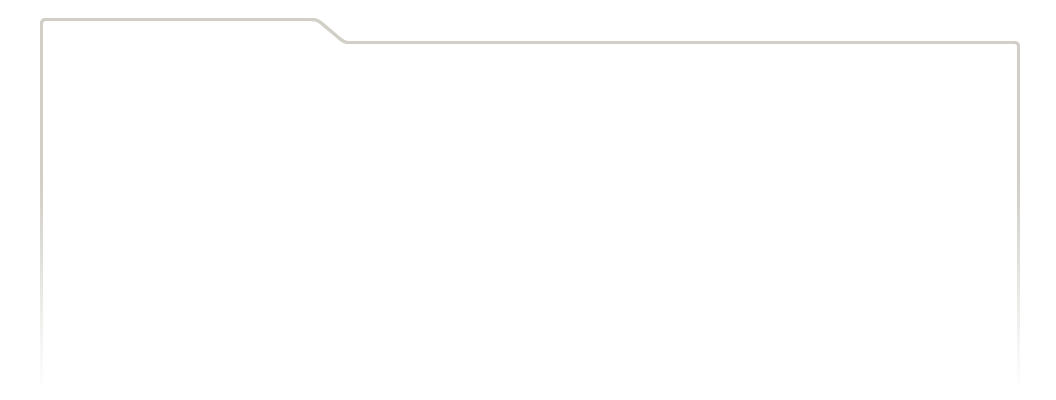
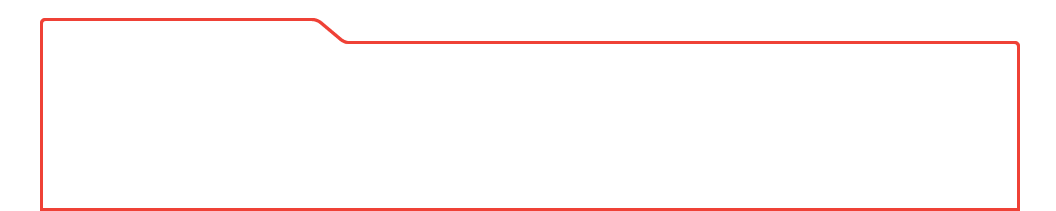
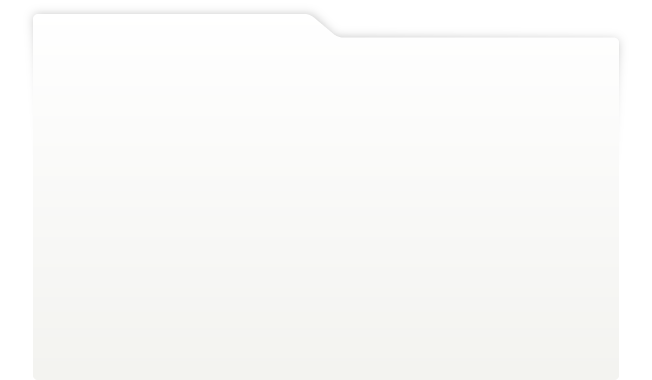
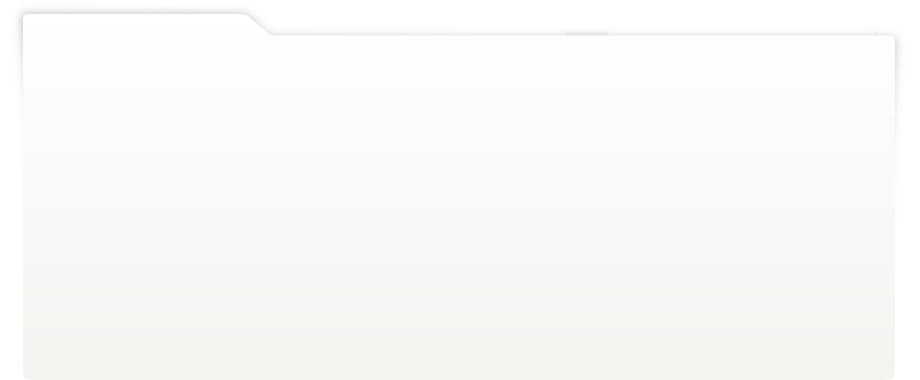
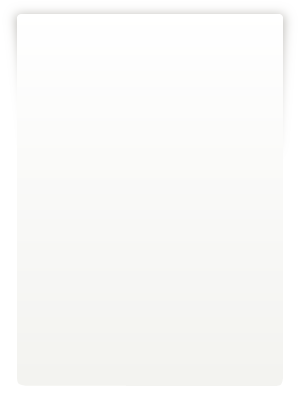
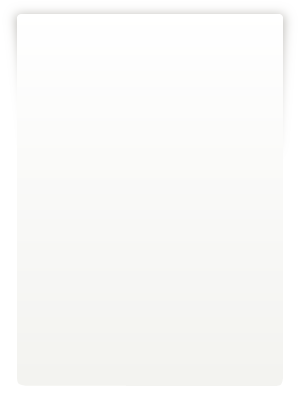
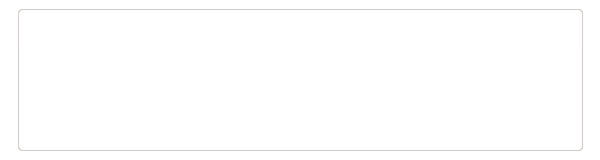
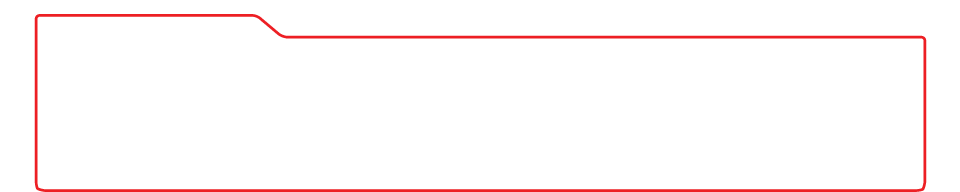
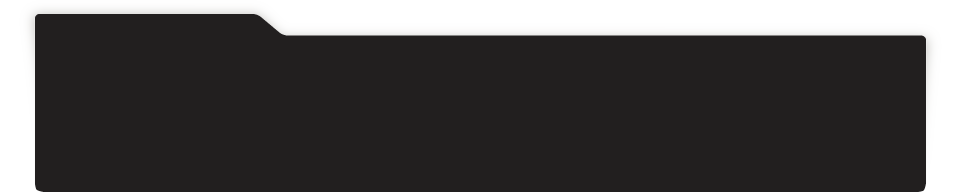
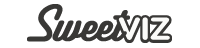
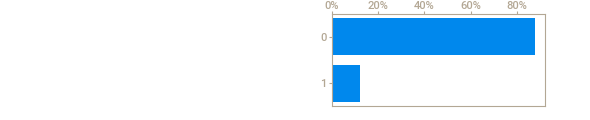
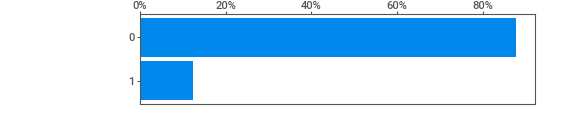
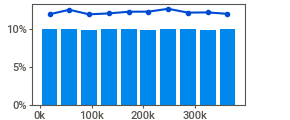
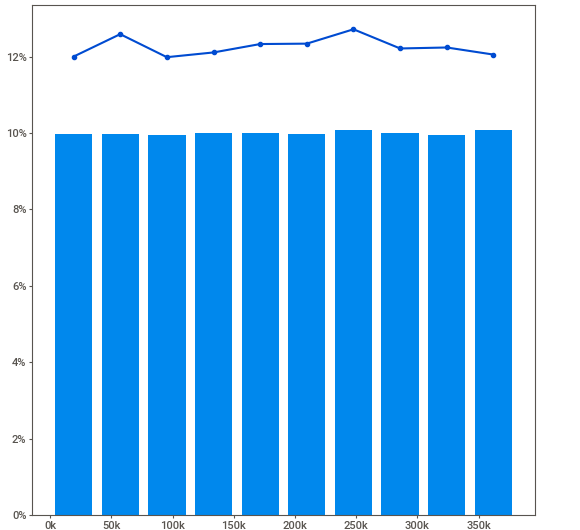
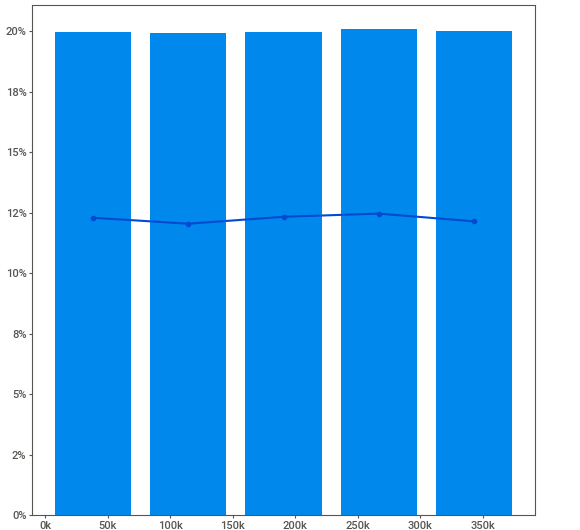
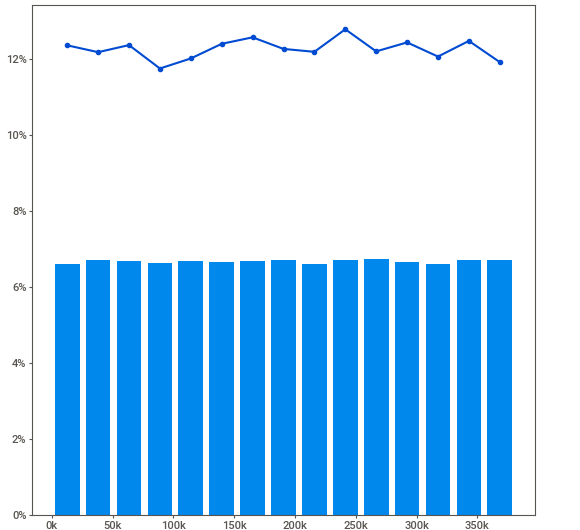
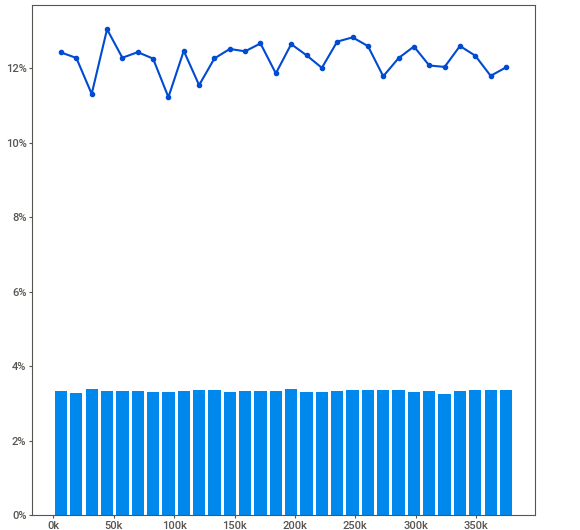
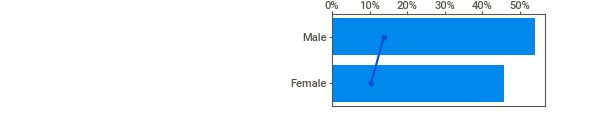
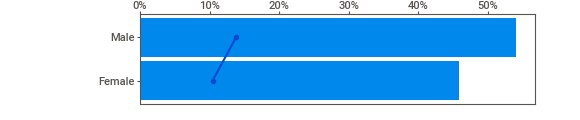
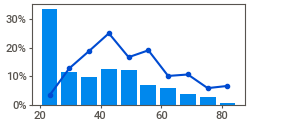
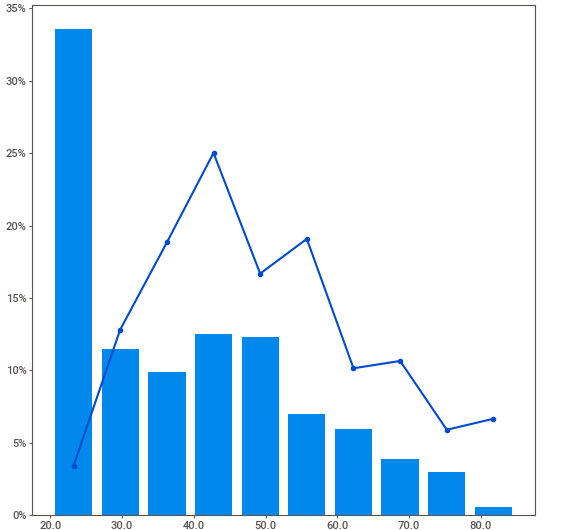
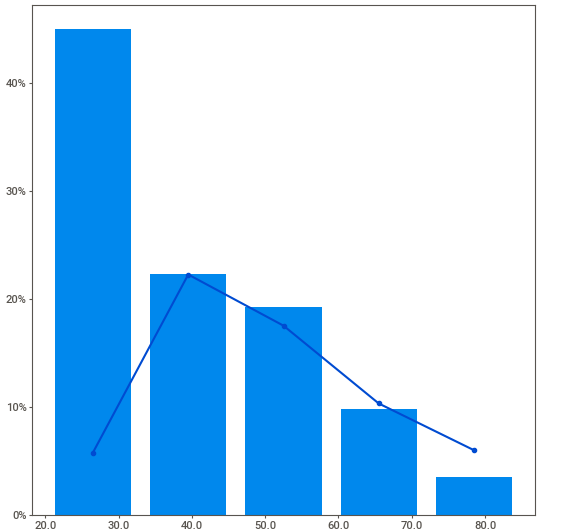
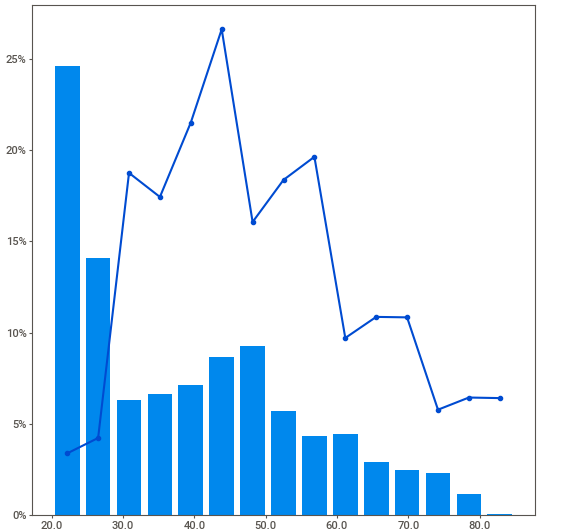
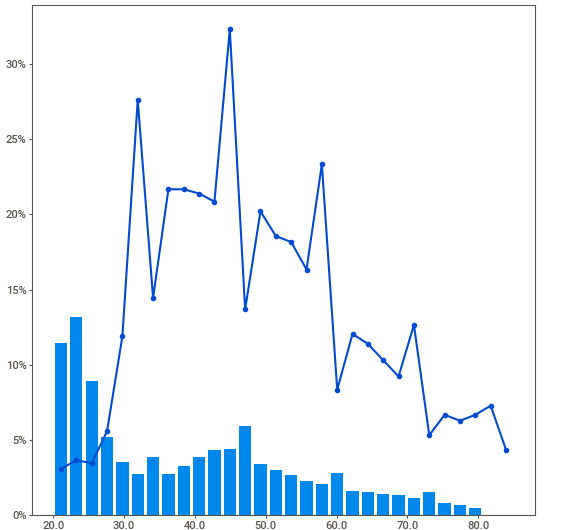
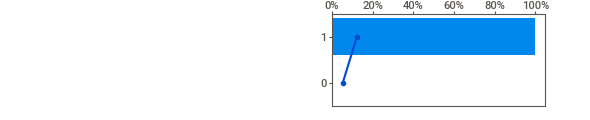
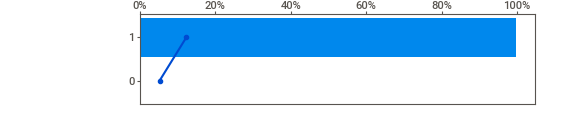
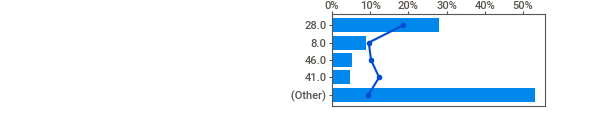
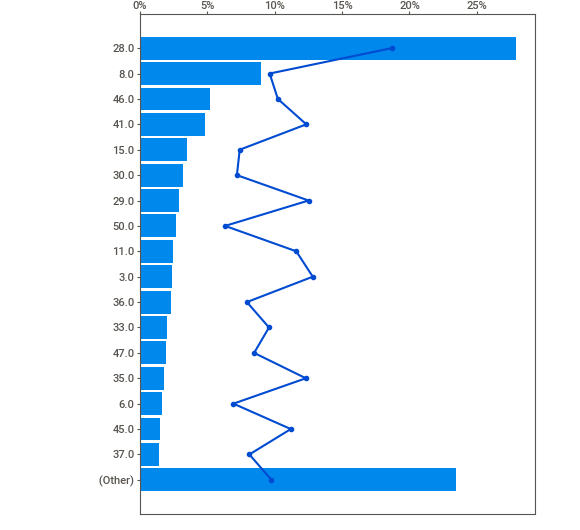
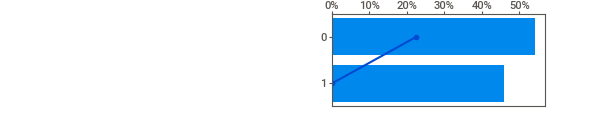
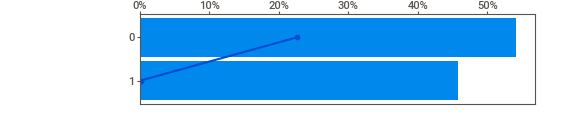
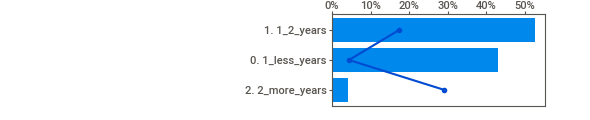
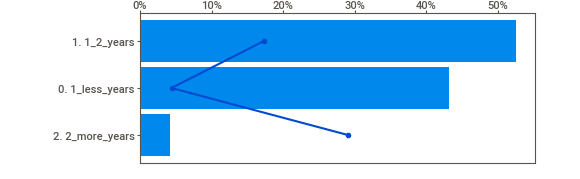
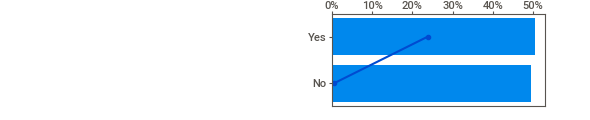
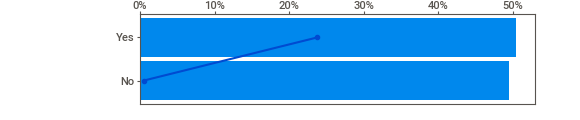
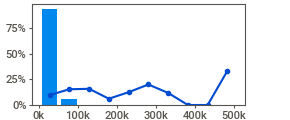
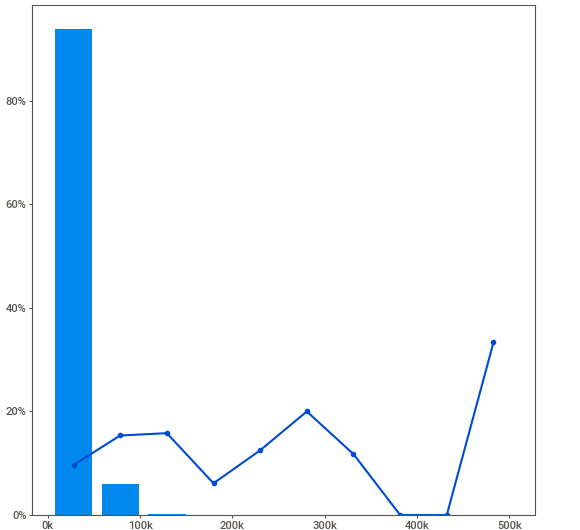
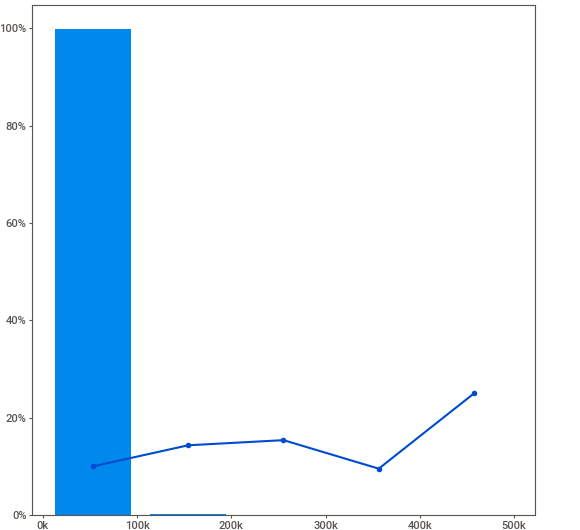
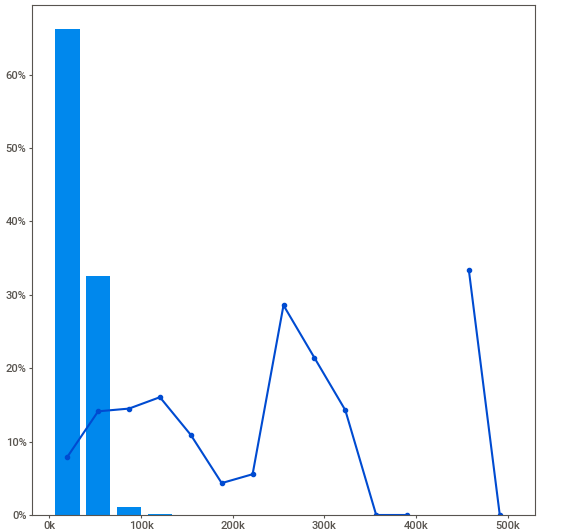
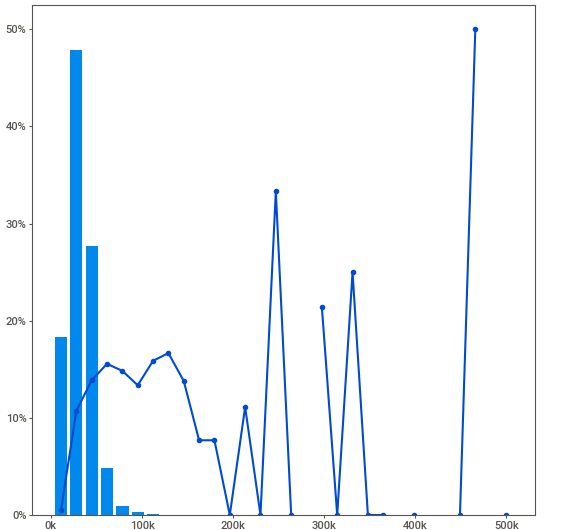
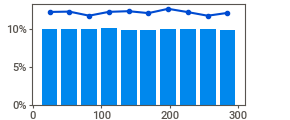
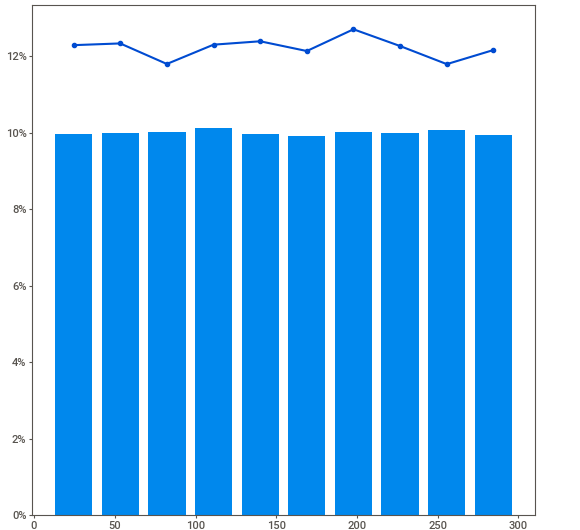
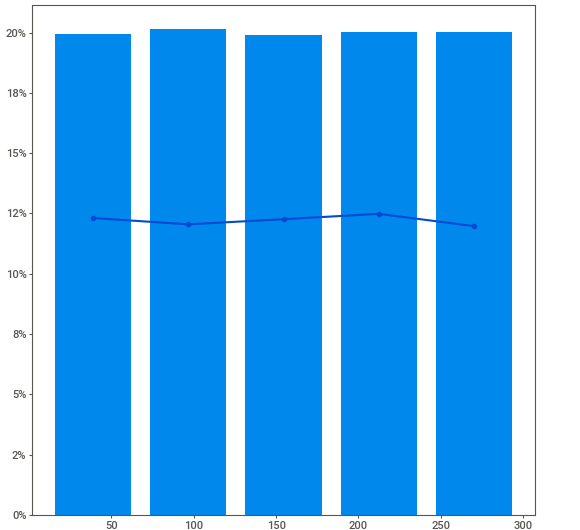
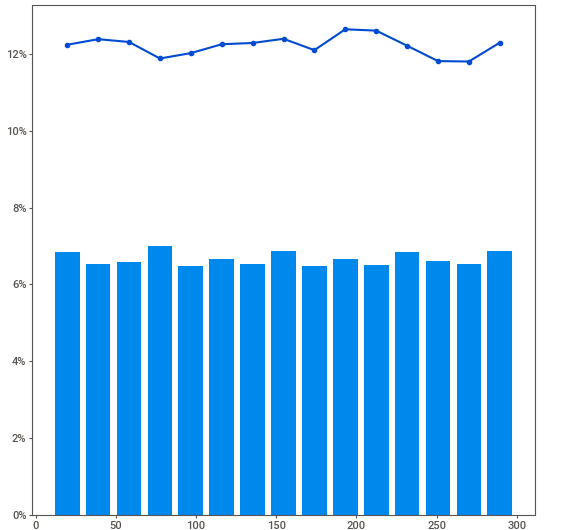
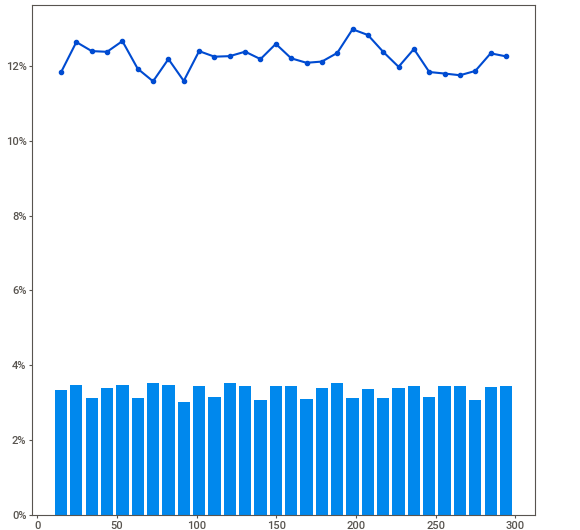
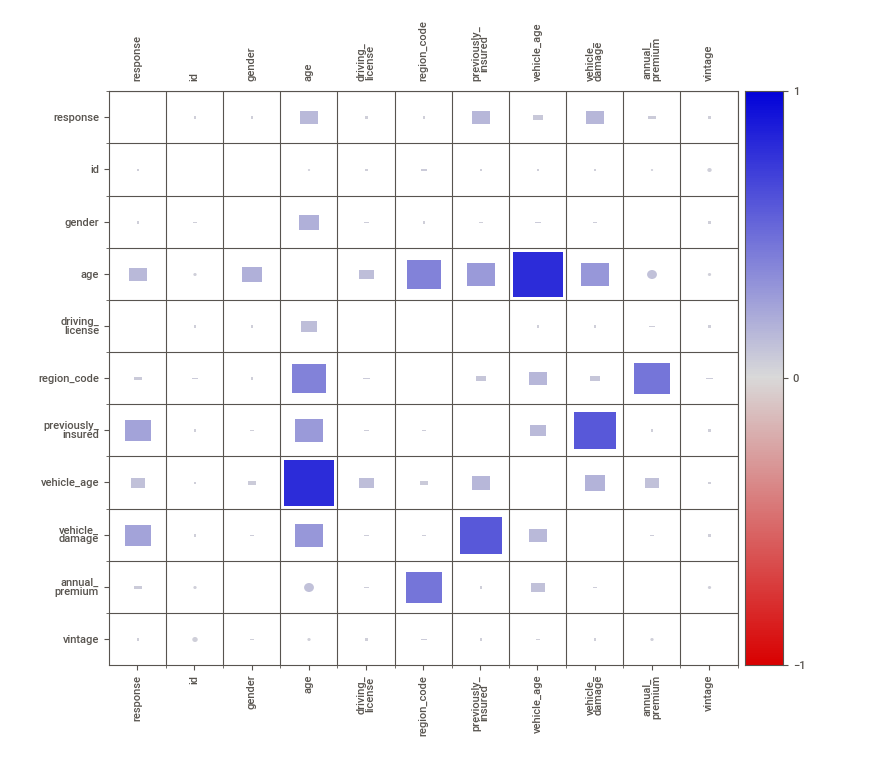
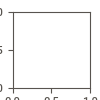

In [74]:
my_report = sv.analyze(df2,target_feat='response')
my_report.show_html("descritive analysis.html")
my_report.show_notebook()

In [75]:
df4.select_dtypes(include='object').columns

Index(['gender', 'region_code', 'vehicle_age', 'vehicle_damage',
       'policy_sales_channel'],
      dtype='object')

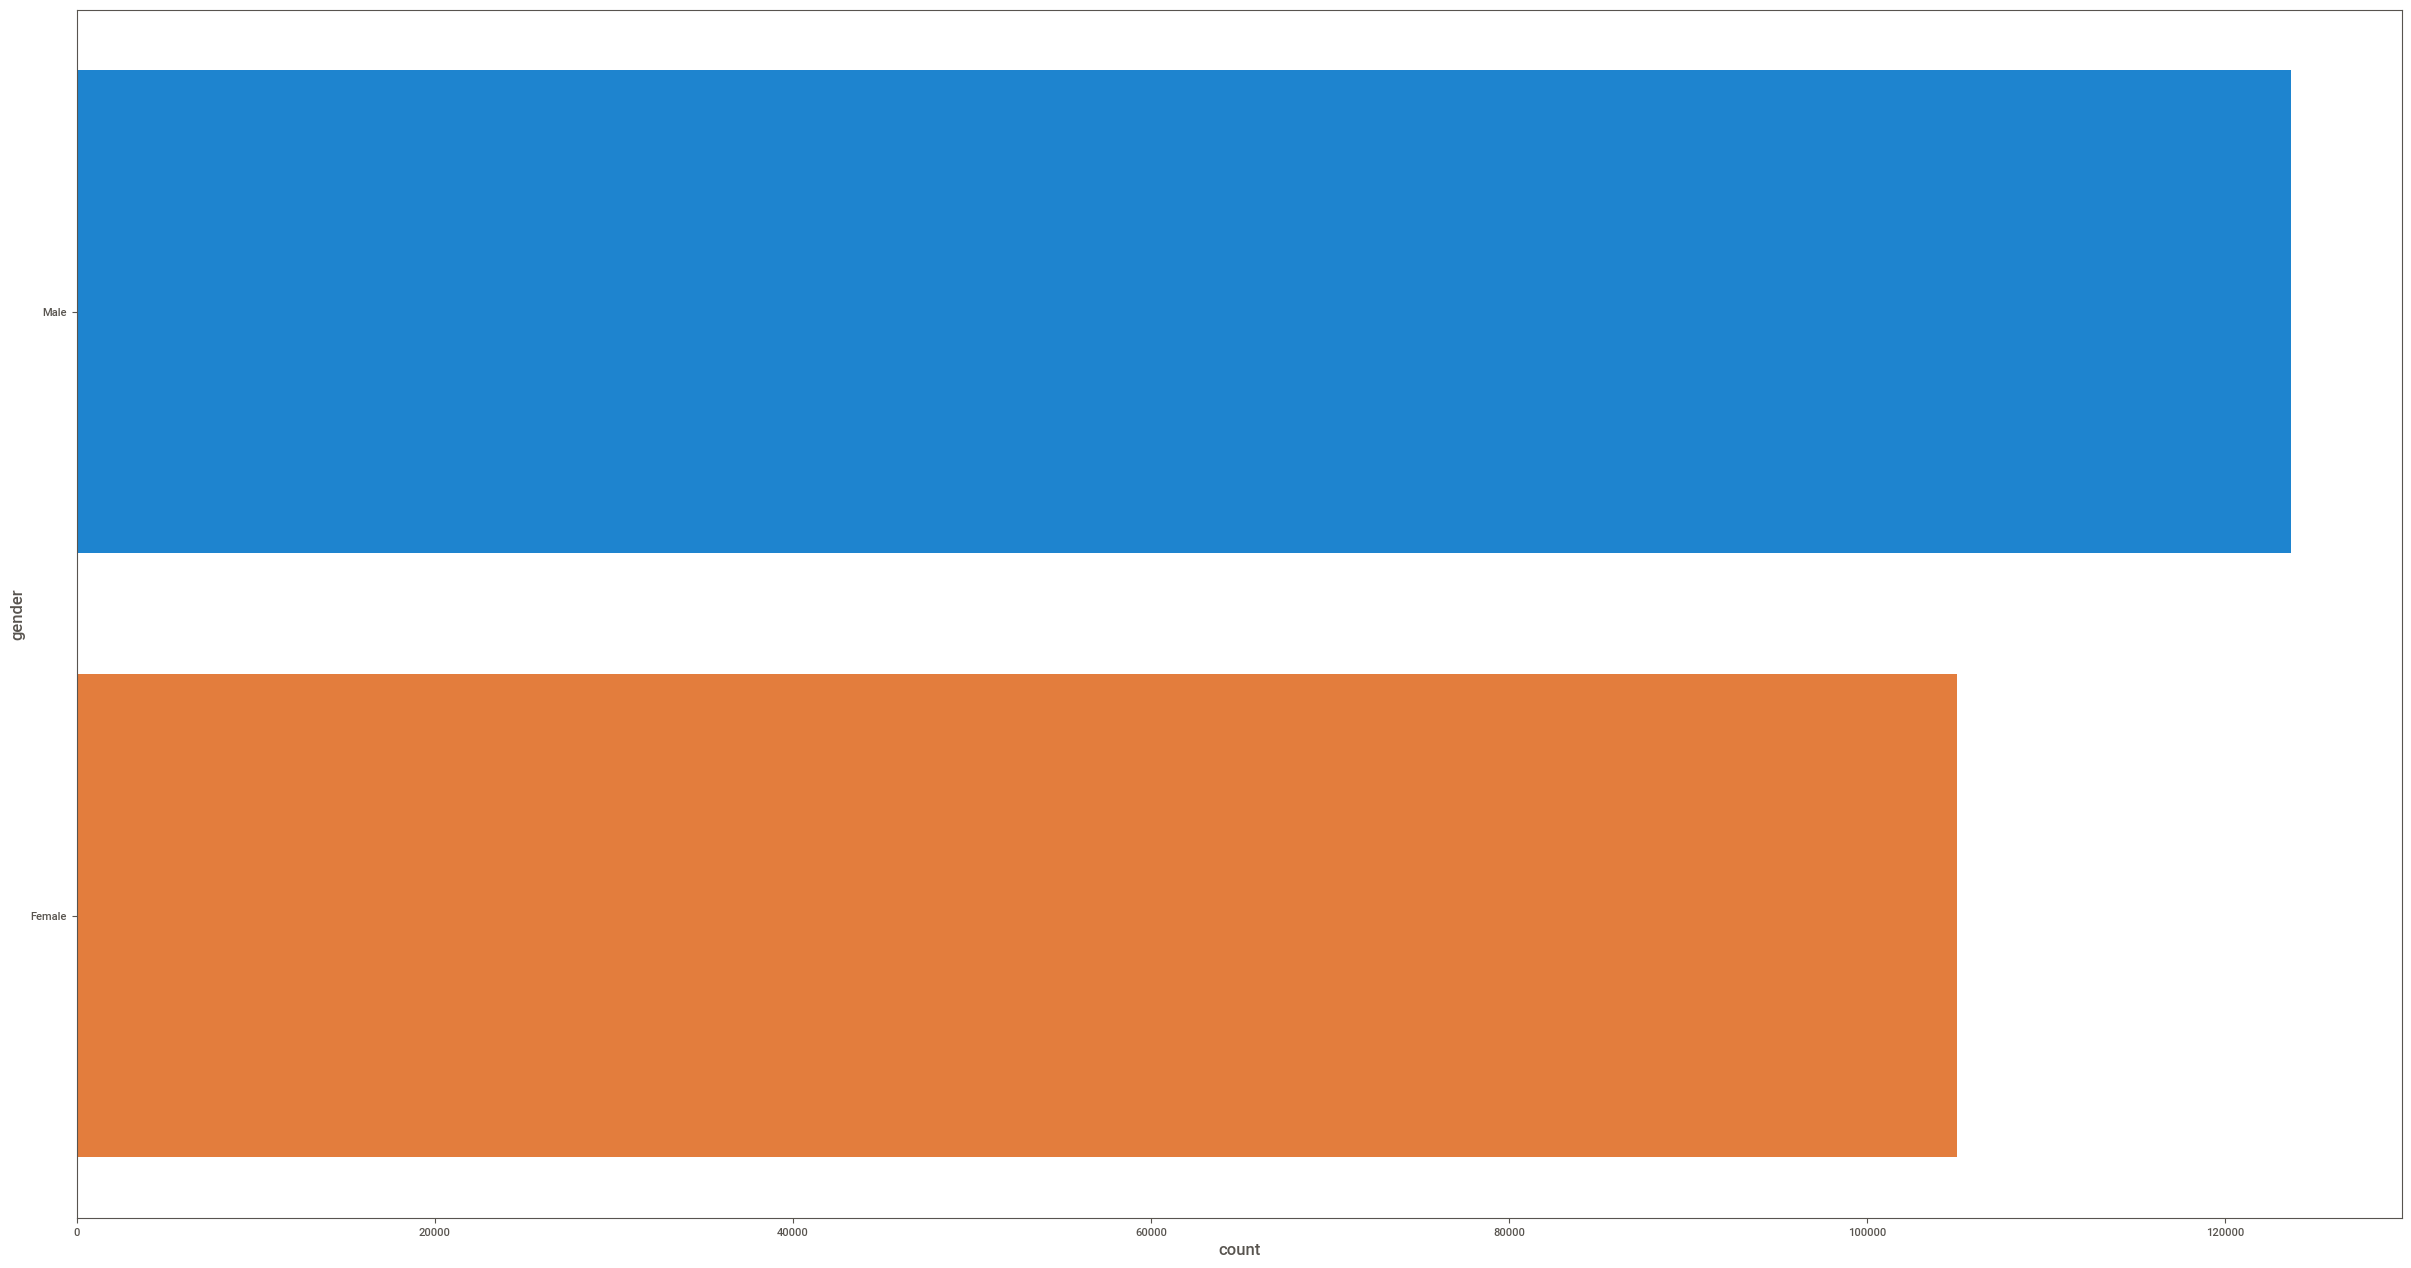

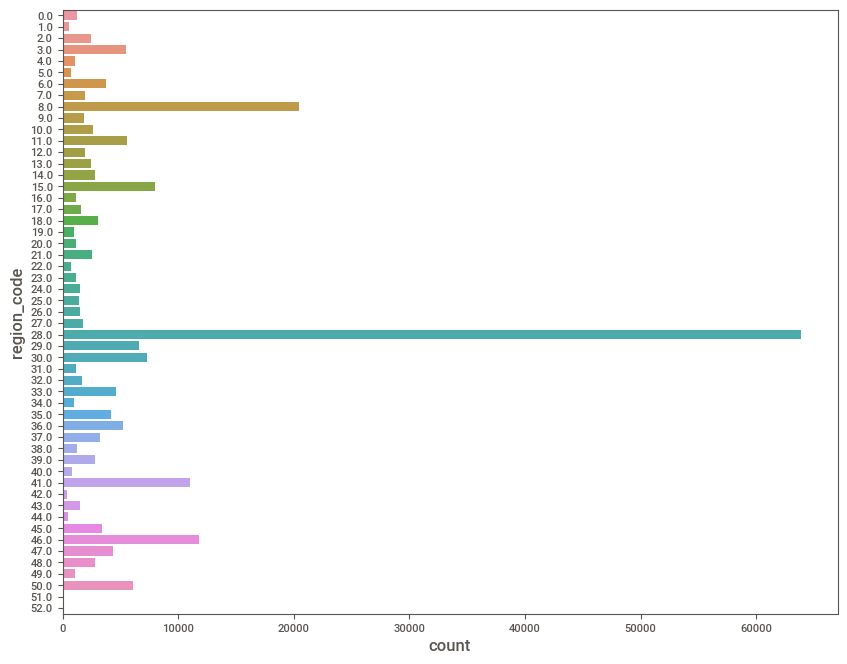

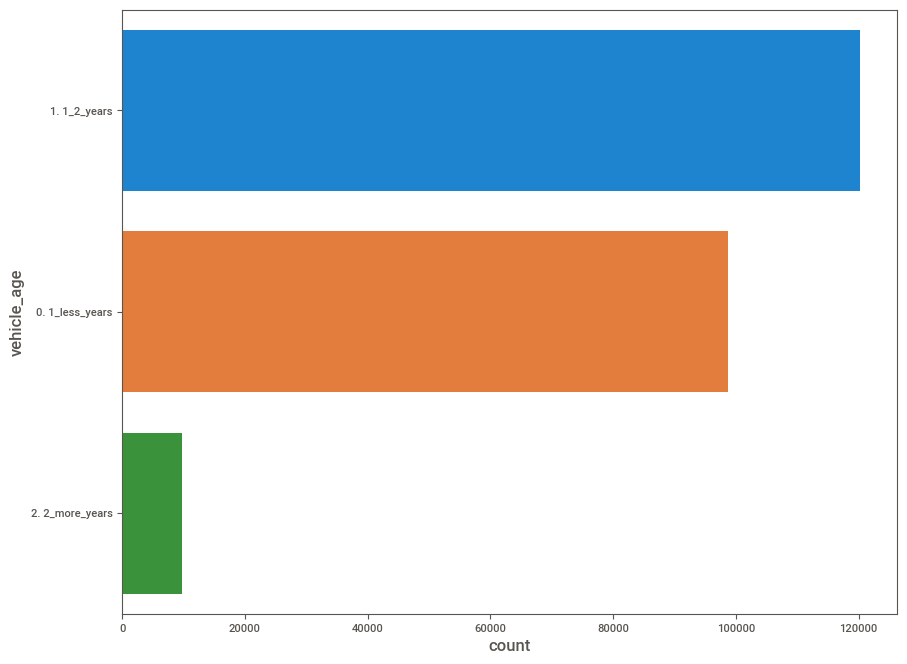

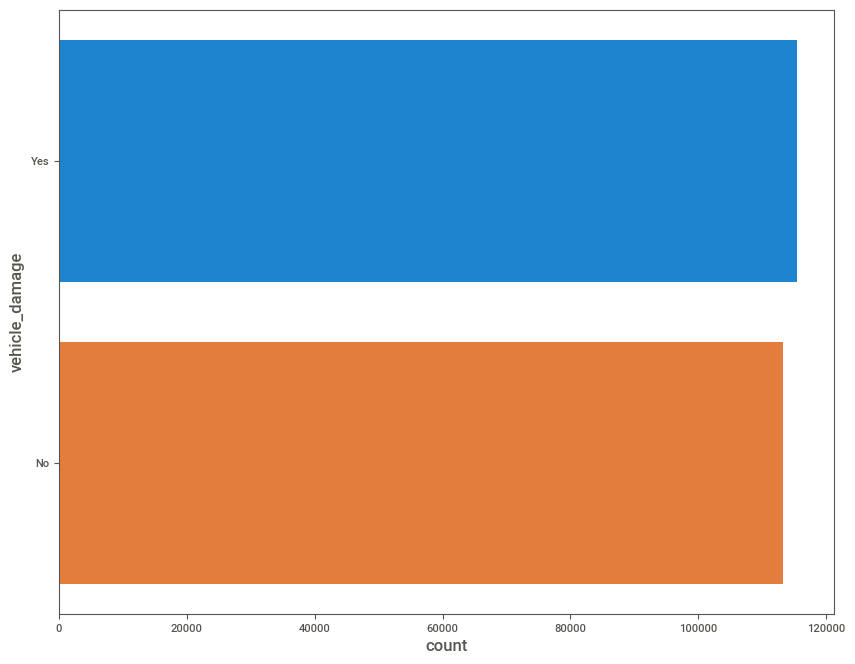

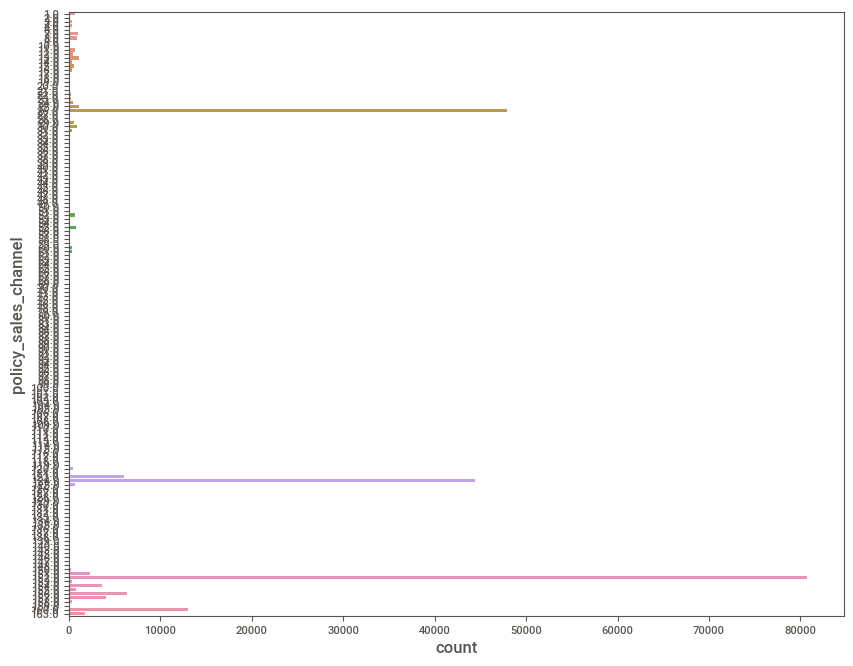

<Figure size 1000x800 with 0 Axes>

In [76]:
for i in df4.select_dtypes(include='object').columns:
    sns.countplot(y=df4[i])
    plt.show()
    fig = plt.gcf()
    fig.set_size_inches(10, 8)

## 4.2 bivariate analysis and hypoteses testing

### H1. Customers with HIGH ASSOCIATE TIME with the company buys MORE vehicle insurance.
### **FALSE** There's no relationship between Associate Time and propensity buting vehicle insurance.

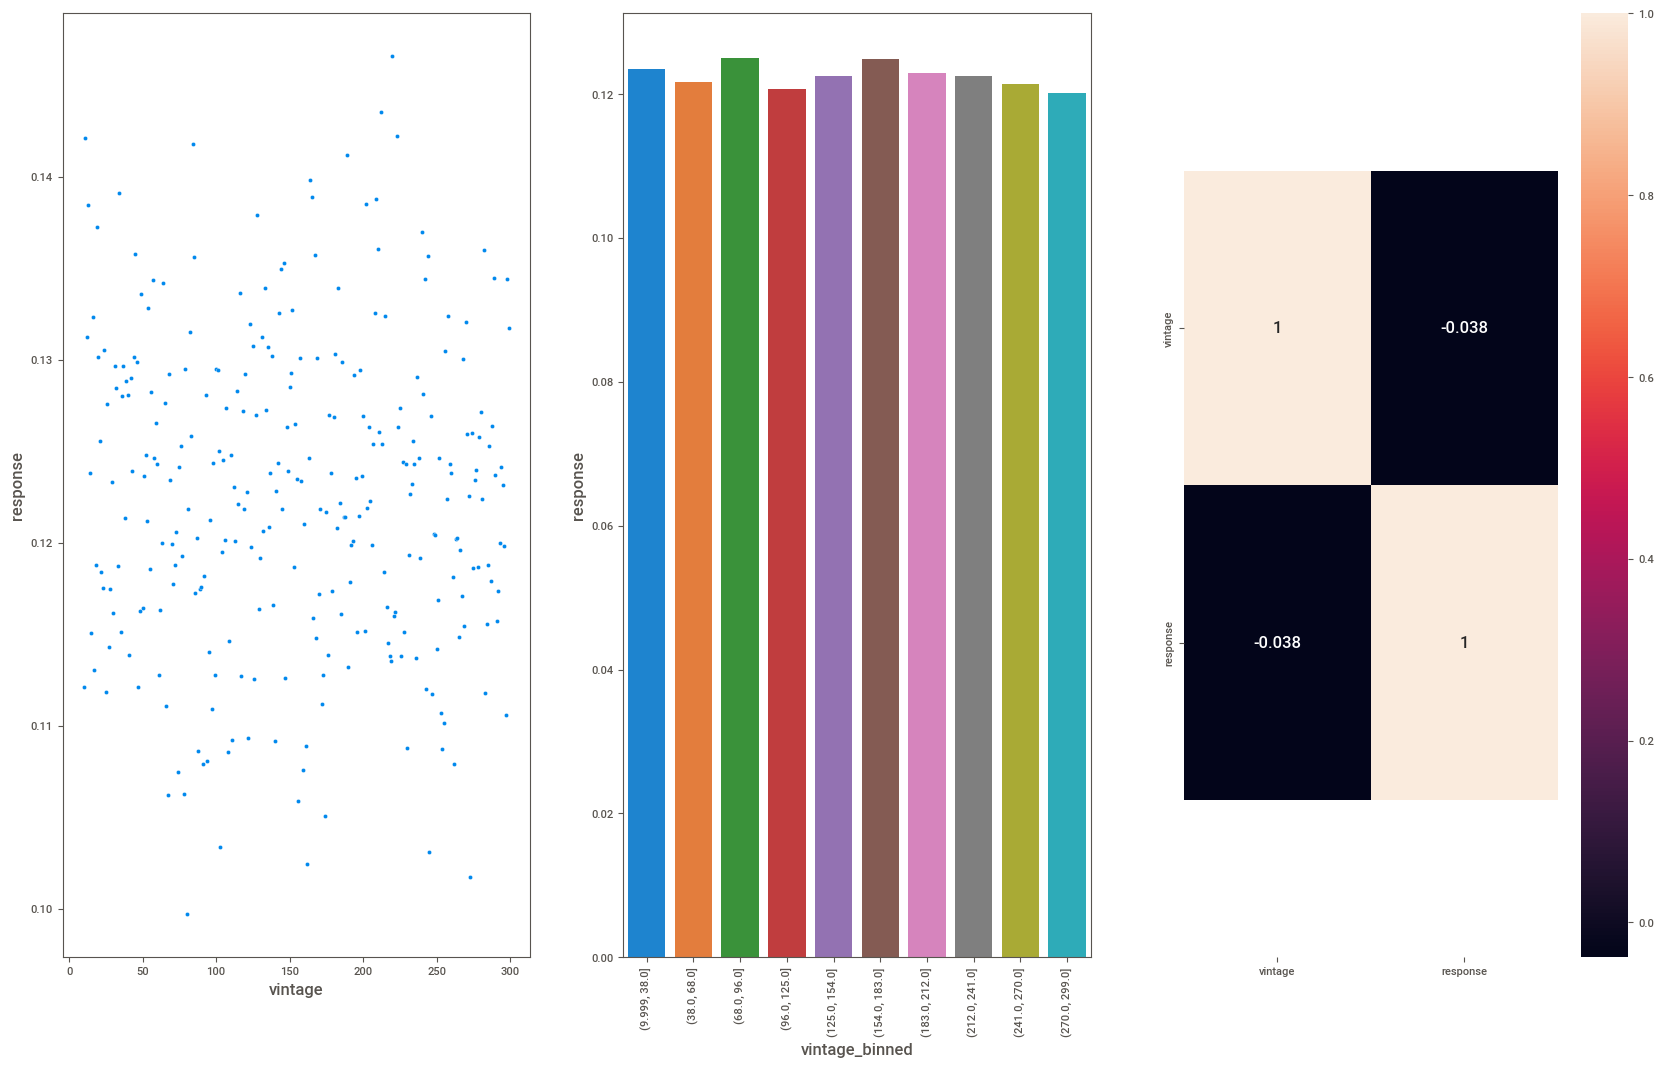

In [21]:
aux1 = df4[['vintage', 'response']].groupby( 'vintage' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='vintage', y='response', data=aux1 );

plt.subplot( 1, 3, 2 )
aux1['vintage_binned']=pd.qcut(df4['vintage'],10)
aux2 = aux1[['vintage_binned', 'response']].groupby( 'vintage_binned' ).mean().reset_index()
sns.barplot( x='vintage_binned', y='response', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

### H2. Previously insured customers buys MORE vehicle insurance.
### **FALSE** Previously insured customers buys LESS vehicle insurance.

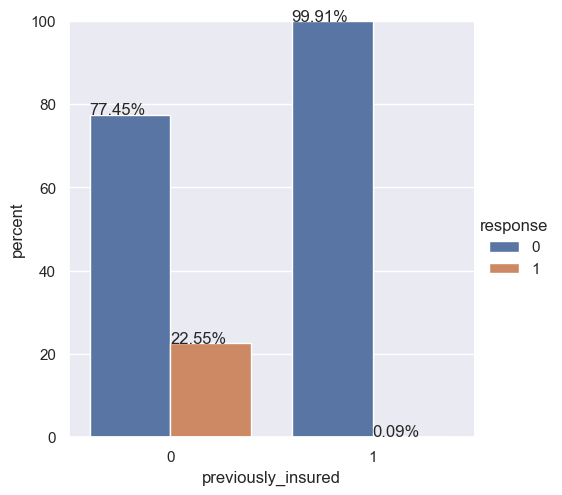

In [22]:
sns.set(rc={'figure.figsize':(10,8)})


aux = df4.groupby('previously_insured')['response'].value_counts(normalize=True)
aux = aux.mul(100)
aux = aux.rename('percent').reset_index()

g = sns.catplot(x='previously_insured',y='percent',hue='response',kind='bar',data=aux)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)


### H3. Customers with driver licence buys MORE vehicle insurance.
### **TRUE** Customers with driver licence buys MORE vehicle insurance.

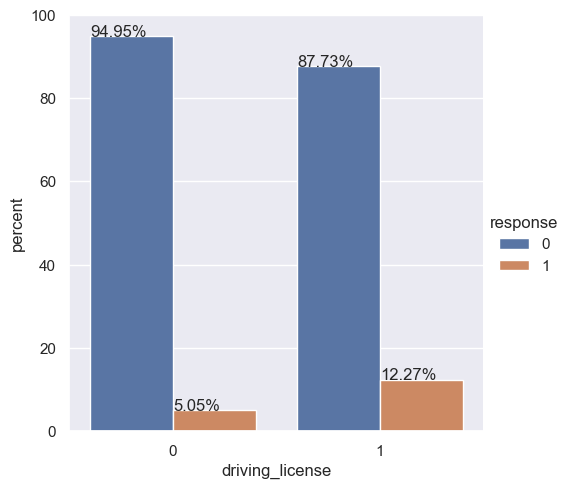

In [23]:
sns.set(rc={'figure.figsize':(10,8)})


aux = df4.groupby('driving_license')['response'].value_counts(normalize=True)
aux = aux.mul(100)
aux = aux.rename('percent').reset_index()

g = sns.catplot(x='driving_license',y='percent',hue='response',kind='bar',data=aux)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

### **H4.** OLDERS customers buys MORE vehicle insurance.
### **FALSE** OLDERS customers buys LESS vehicle insurance, but the youngest customers either.

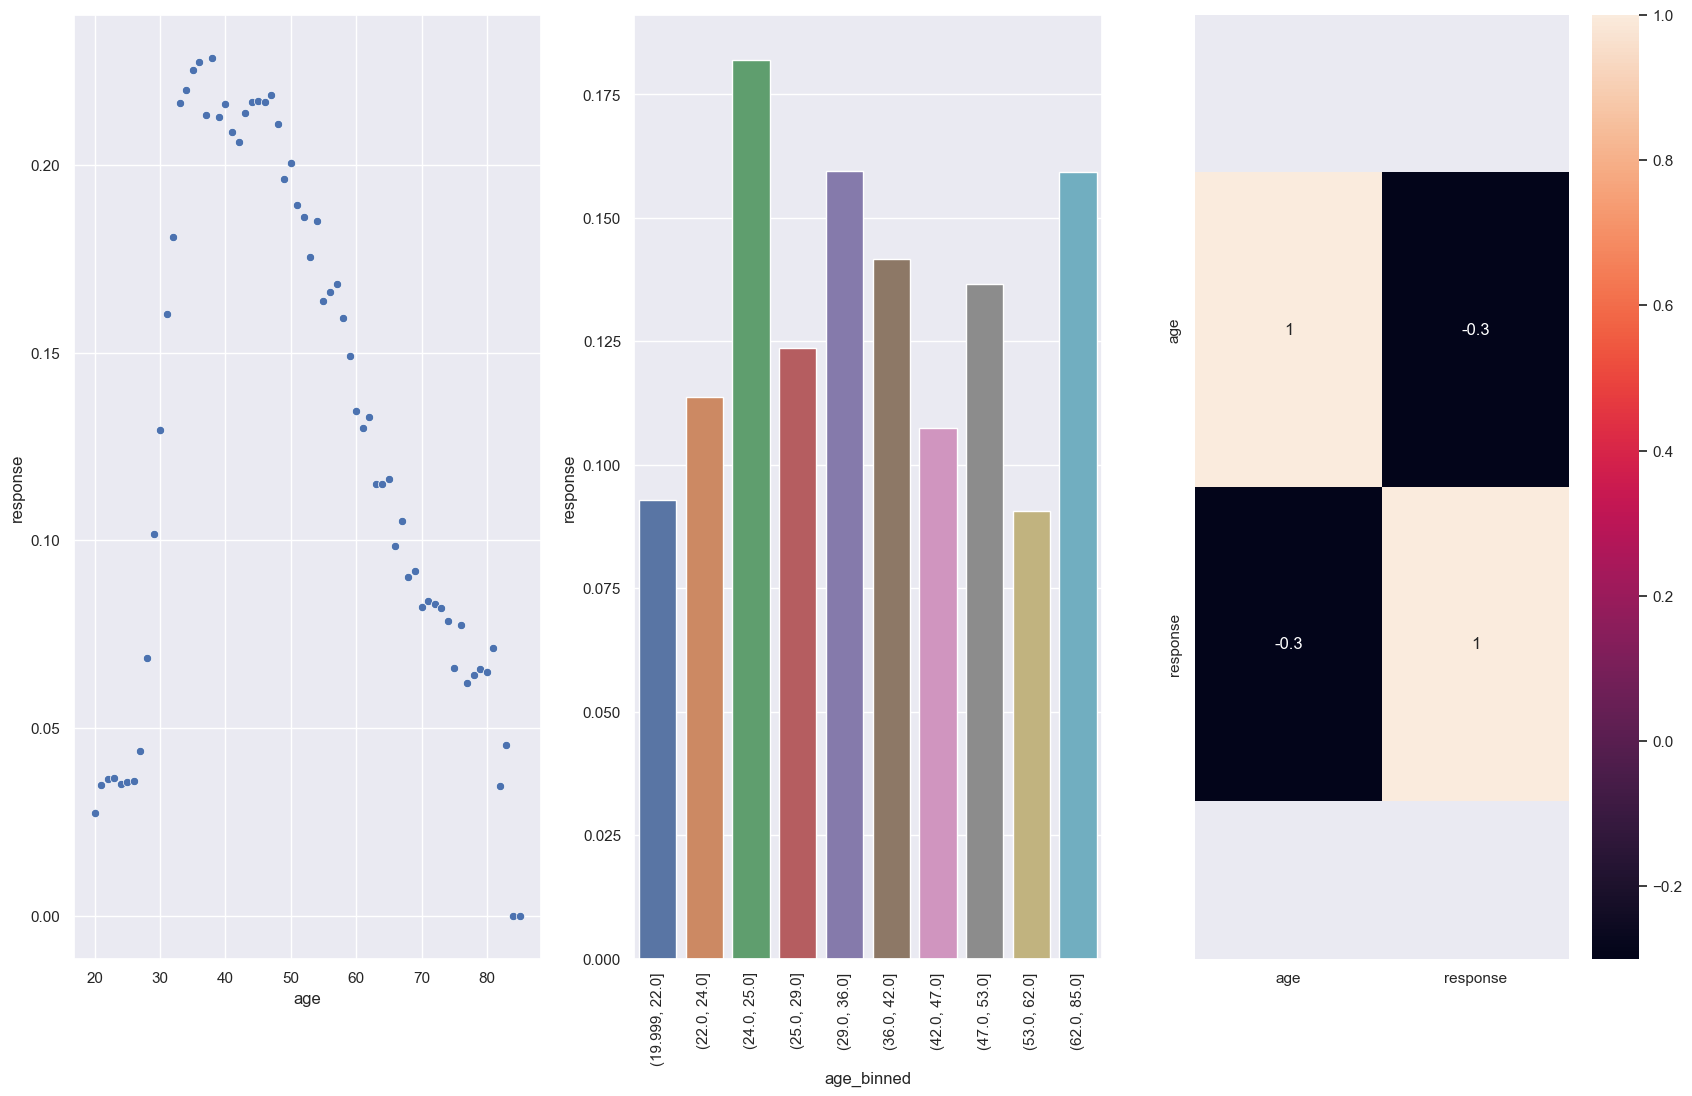

In [24]:
aux1 = df4[['age', 'response']].groupby( 'age' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='age', y='response', data=aux1 );

plt.subplot( 1, 3, 2 )
aux1['age_binned']=pd.qcut(df4['age'],10)
aux2 = aux1[['age_binned', 'response']].groupby( 'age_binned' ).mean().reset_index()
sns.barplot( x='age_binned', y='response', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

### **H5.** There's a difference in propensity to purchase between customers GENDERS.
### **True** MALE customers are slighly more likely to buy vehicle insurance.

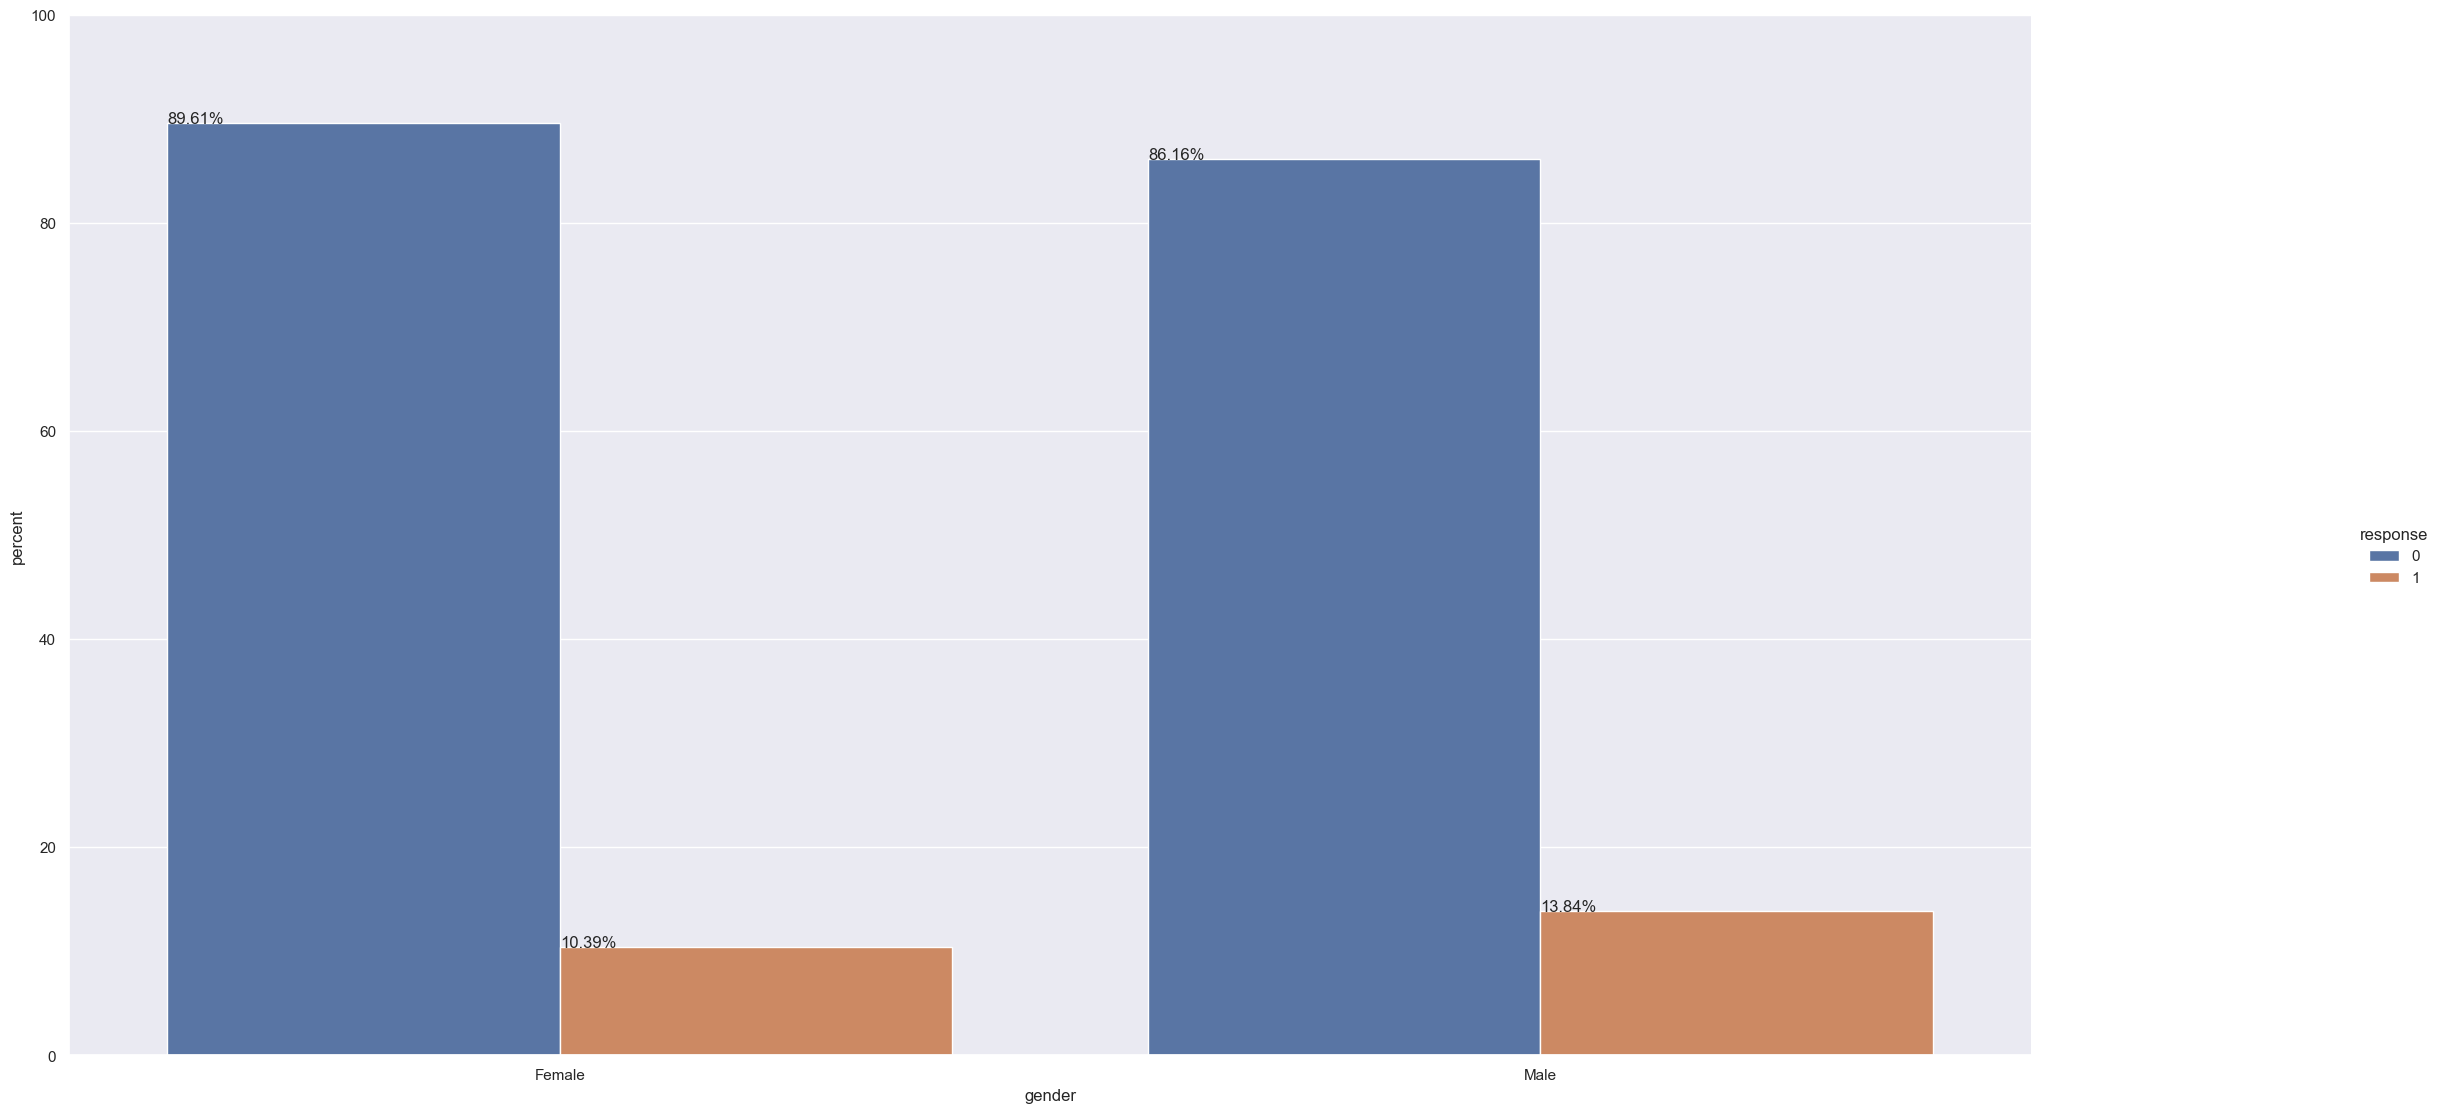

In [25]:
aux = df4.groupby('gender')['response'].value_counts(normalize=True)
aux = aux.mul(100)
aux = aux.rename('percent').reset_index()

g = sns.catplot(x='gender',y='percent',hue='response',kind='bar',data=aux)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    fig = plt.gcf()
    fig.set_size_inches(27.5, 12.5)

### H6. There's a DIFFERENCE in propensity to purchase between REGION CODE
### True. There's regions with more propense purchase customers.

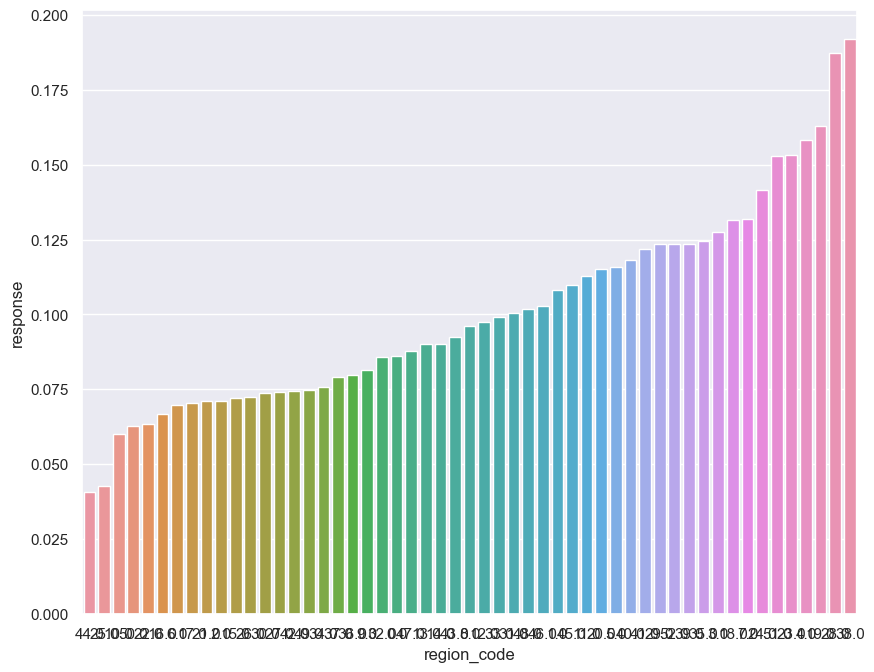

In [26]:
aux1 = df4[['region_code', 'response']].groupby( 'region_code' ).mean().reset_index().sort_values('response')
aux1['region_code']=aux1['region_code'].astype(str)

sns.barplot( x='region_code', y='response' ,data=aux1);

### H7. Customers with HIGH vehicle insurance price should buys LESS vehicle insurance.
### FALSE the HIGHEST insurance prices is MORE BOUGHT by customers.

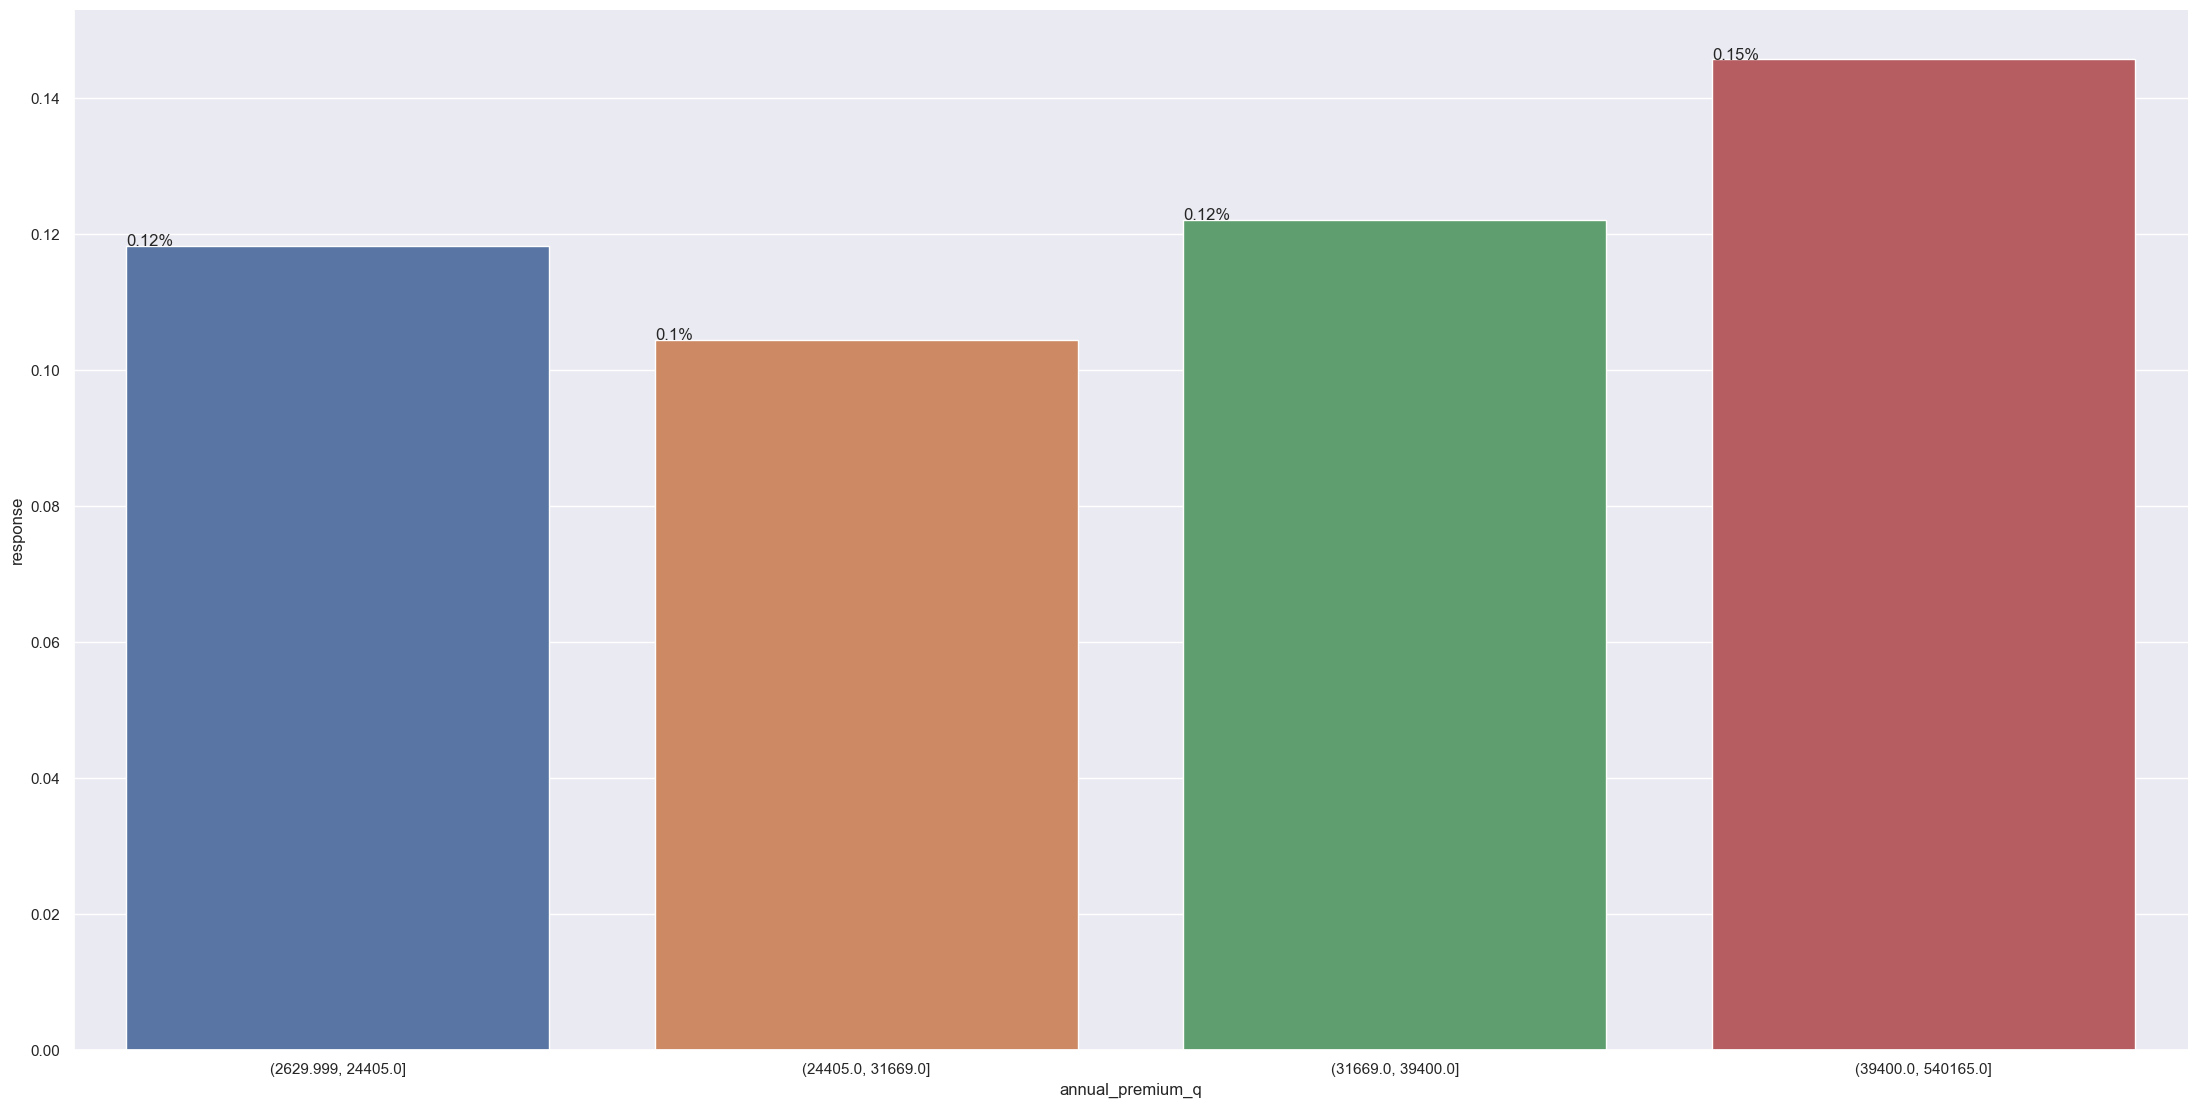

In [27]:
aux1=df4.copy()
aux1['annual_premium_q']=pd.qcut(aux1['annual_premium'],4)
aux1=aux1.groupby(['annual_premium_q']).agg({'response':'mean'}).reset_index()
g=sns.catplot(x='annual_premium_q',y='response',data=aux1,kind='bar')
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    fig = plt.gcf()
    fig.set_size_inches(27.5, 12.5)

### H8. UNDERAGED vehicles are MORE likely to be insured by customers.
###  **TRUE** UNDERAGED vehicles are MORE likely to be insured by customers.

1. 1_2_years       200316
0. 1_less_years    164786
2. 2_more_years     16007
Name: vehicle_age, dtype: int64


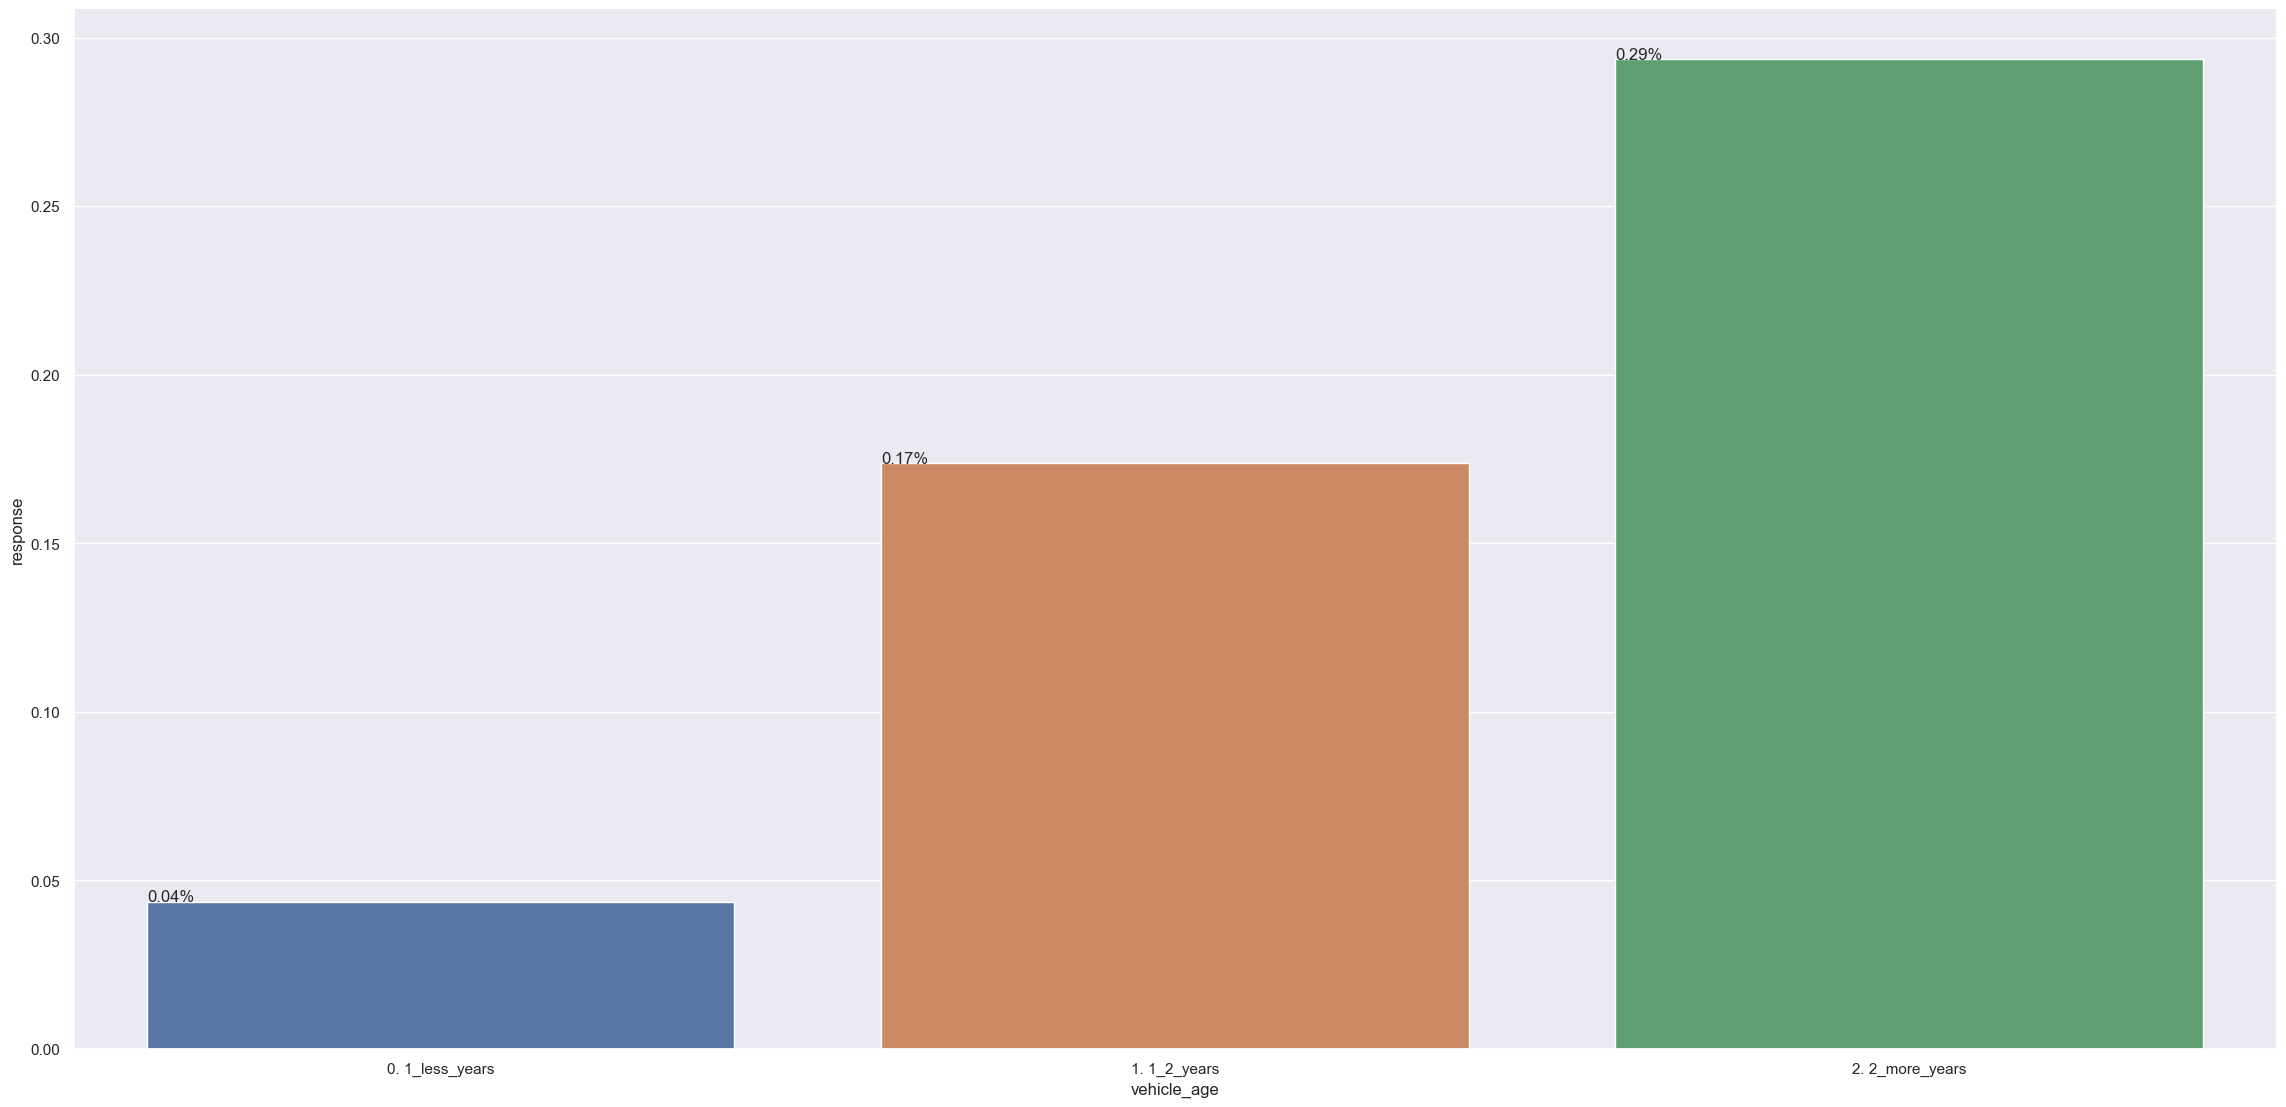

In [28]:
aux1 = df4[['vehicle_age', 'response']].groupby( 'vehicle_age' ).mean().reset_index().sort_values('response')
aux1['vehicle_age']=aux1['vehicle_age'].astype(str)
print(df4['vehicle_age'].value_counts())
g=sns.catplot(x='vehicle_age',y='response',data=aux1,kind='bar')
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    fig = plt.gcf()
    fig.set_size_inches(27.5, 12.5)

In [29]:
### H9. DAMAGED vehicles are MORE likely to be insured by customers.

###  **True** DAMAGED vehicles are VERY MORE LIKELY to be insured by customers.

<AxesSubplot:xlabel='vehicle_damage', ylabel='response_count'>

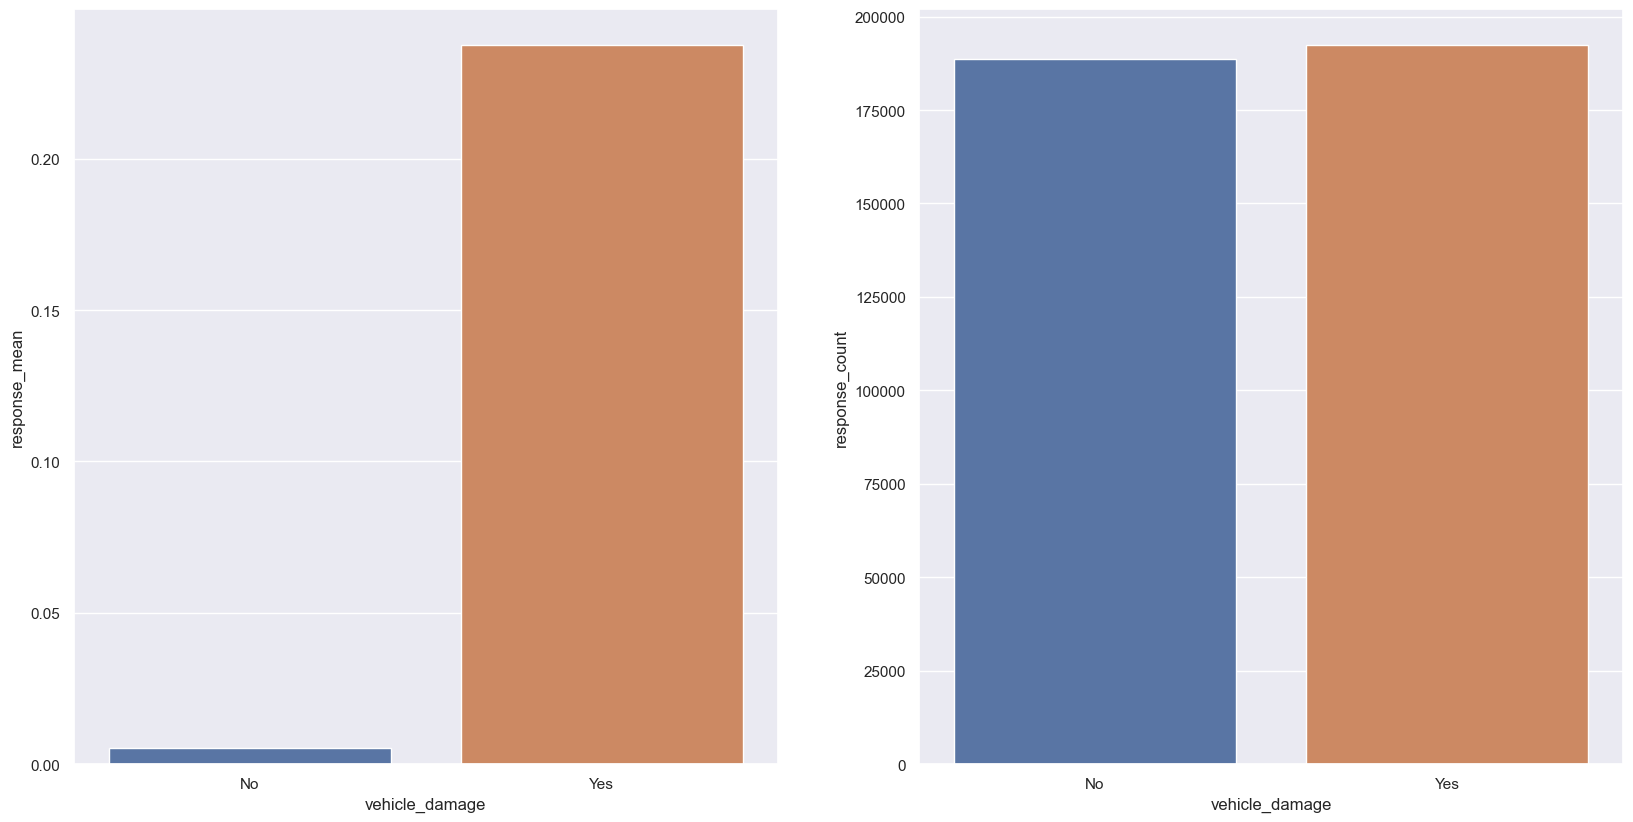

In [30]:
aux1 = df4.groupby( 'vehicle_damage').agg(response_count=('response','count'),
                                                response_mean=('response','mean')).reset_index().sort_values('vehicle_damage')

fig = plt.figure(figsize=(20,10))
specs=gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1= fig.add_subplot(specs[0,0])
ax2= fig.add_subplot(specs[0,1])

g=sns.barplot(x='vehicle_damage',y='response_mean',data=aux1,ax=ax1)
sns.barplot(x='vehicle_damage',y='response_count',data=aux1,ax=ax2)


### H9. There is different insurance buy propensity according to policy sales channel. 

###  **True** there is a considerable difference in buy propensity depending to policy sales channel, however there is a big imbalance between the channels.

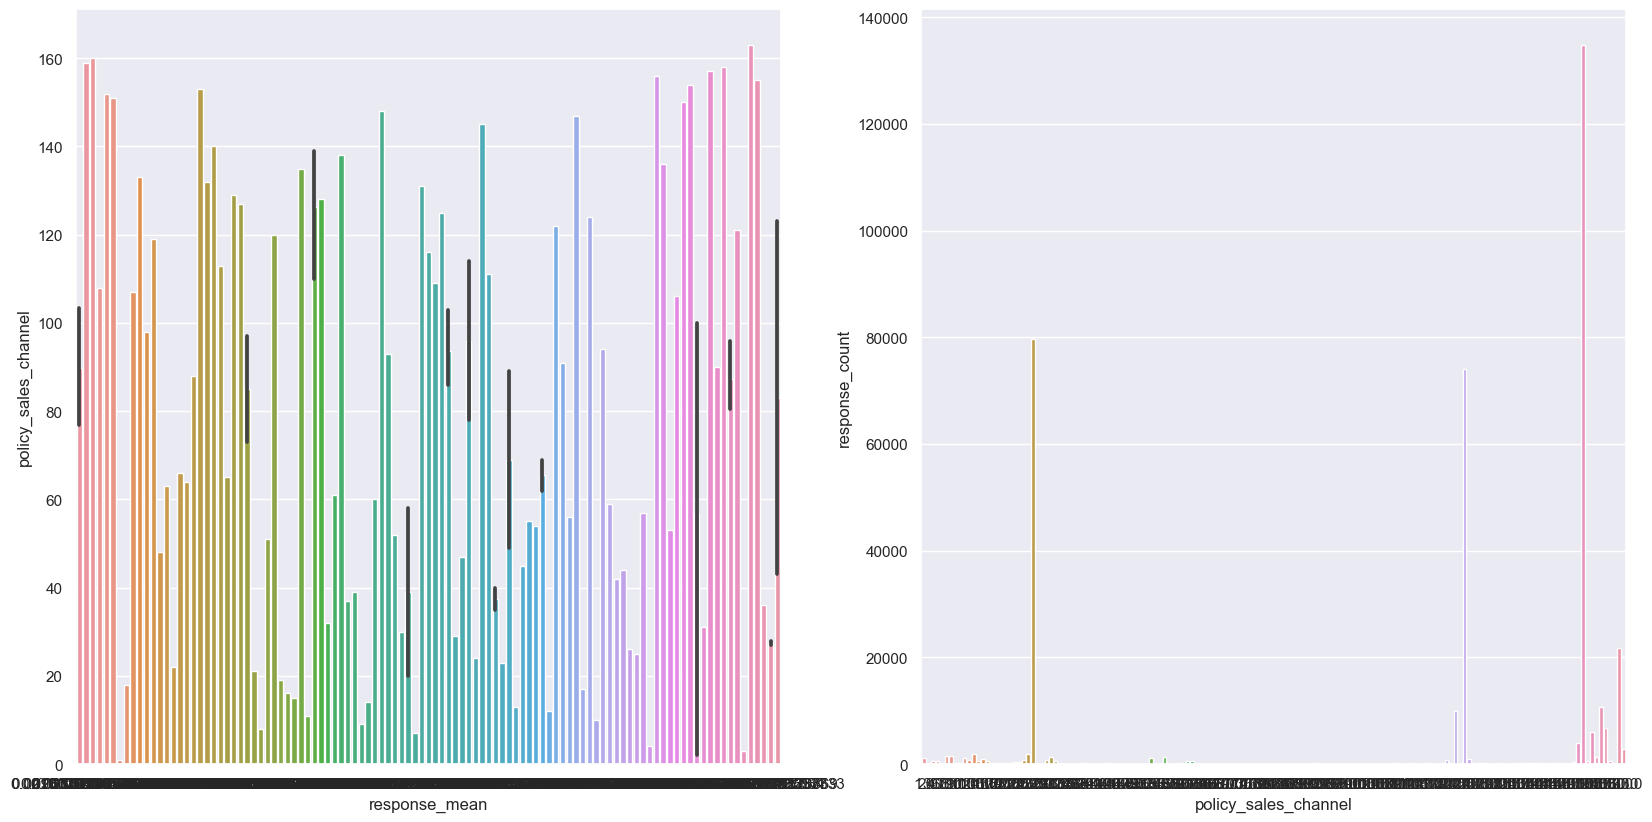

In [31]:
aux1 = df4.groupby( 'policy_sales_channel' ).agg(response_count=('response','count'),
                                                response_mean=('response','mean')).reset_index().sort_values('policy_sales_channel')

fig = plt.figure(figsize=(20,10))
specs=gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1= fig.add_subplot(specs[0,0])
ax2= fig.add_subplot(specs[0,1])

g=sns.barplot(y='policy_sales_channel',x='response_mean',data=aux1,ax=ax1)
g=sns.barplot(x='policy_sales_channel',y='response_count',data=aux1,ax=ax2)


## hypoteses summary

In [32]:
hyp={
"Customers with HIGH ASSOCIATE TIME with the company buys MORE vehicle insurance.":False,
"Customers previously insured buys MORE vehicle insurance.":False,
"Customers with driver licence buys MORE vehicle insurance.":True,
"OLDERS customers buys MORE vehicle insurance.":False,
"There's a difference in propensity to purchase between customers GENDERS.":True,
"There's a difference in propensity to purchase between region CODE":True,
"Customers with HIGH vehicle insurance price should buys LESS vehicle insurance.":False,
"UNDERAGED vehicles are MORE likely to be insured by customers.":True,
"There is different insurance buy propensity according to Policy Sales Channel.":True,
}
summary=pd.DataFrame.from_dict(hyp,orient='index').reset_index().rename(columns={'index':'hypotesis',0:'Conclusion'})
summary

,hypotesis,Conclusion
0,Customers with HIGH ASSOCIATE TIME with the co...,False
1,Customers previously insured buys MORE vehicle...,False
2,Customers with driver licence buys MORE vehicl...,True
3,OLDERS customers buys MORE vehicle insurance.,False
4,There's a difference in propensity to purchase...,True
5,There's a difference in propensity to purchase...,True
6,Customers with HIGH vehicle insurance price sh...,False
7,UNDERAGED vehicles are MORE likely to be insur...,True
8,There is different insurance buy propensity ac...,True


## 4.3 multivariate analysis

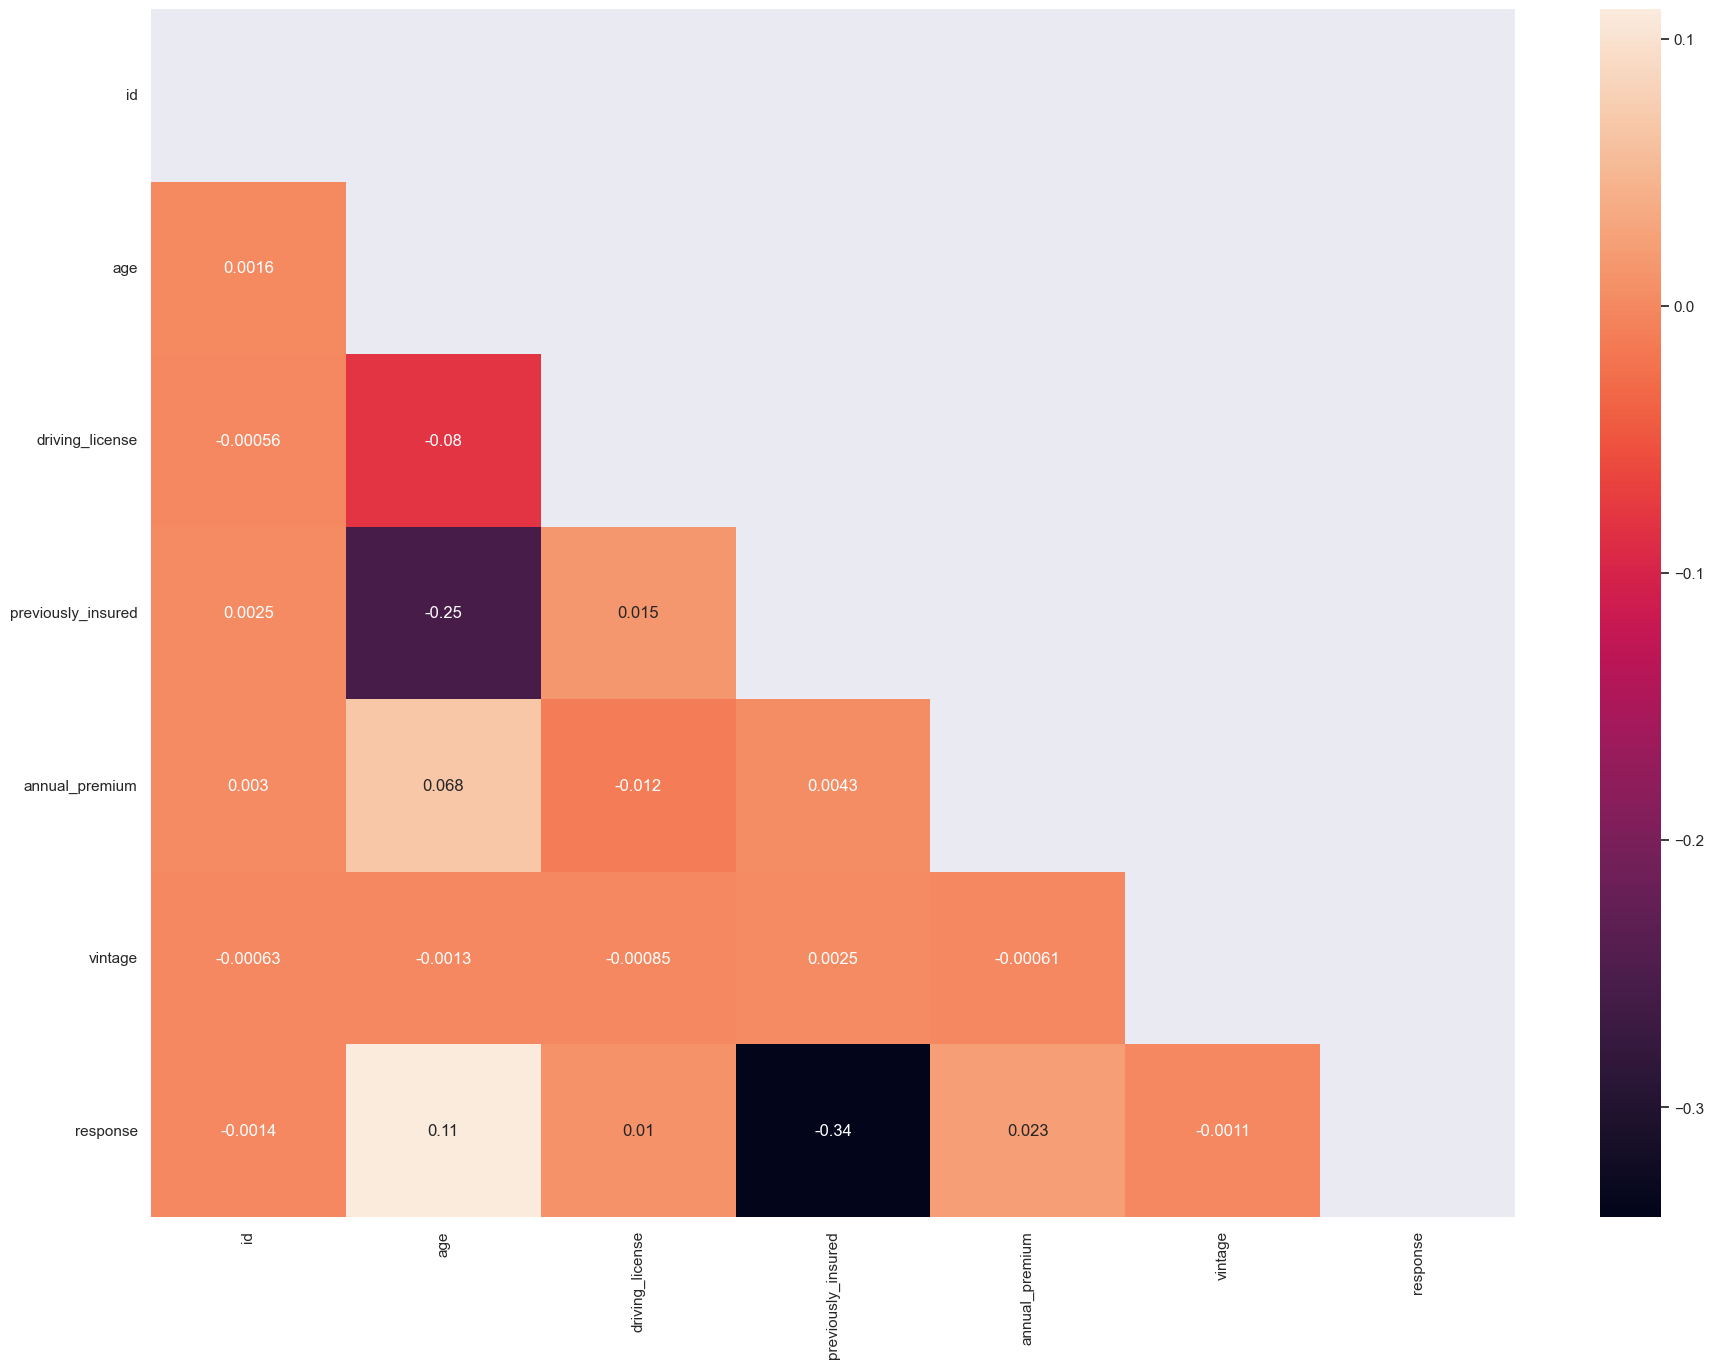

In [33]:
corrs= df2.select_dtypes(include=['float64','int64']).corr(method='pearson')
matrix = np.triu(corrs)
sns.heatmap(corrs,annot=True,mask=matrix)
plt.gcf().set_size_inches(22,16)

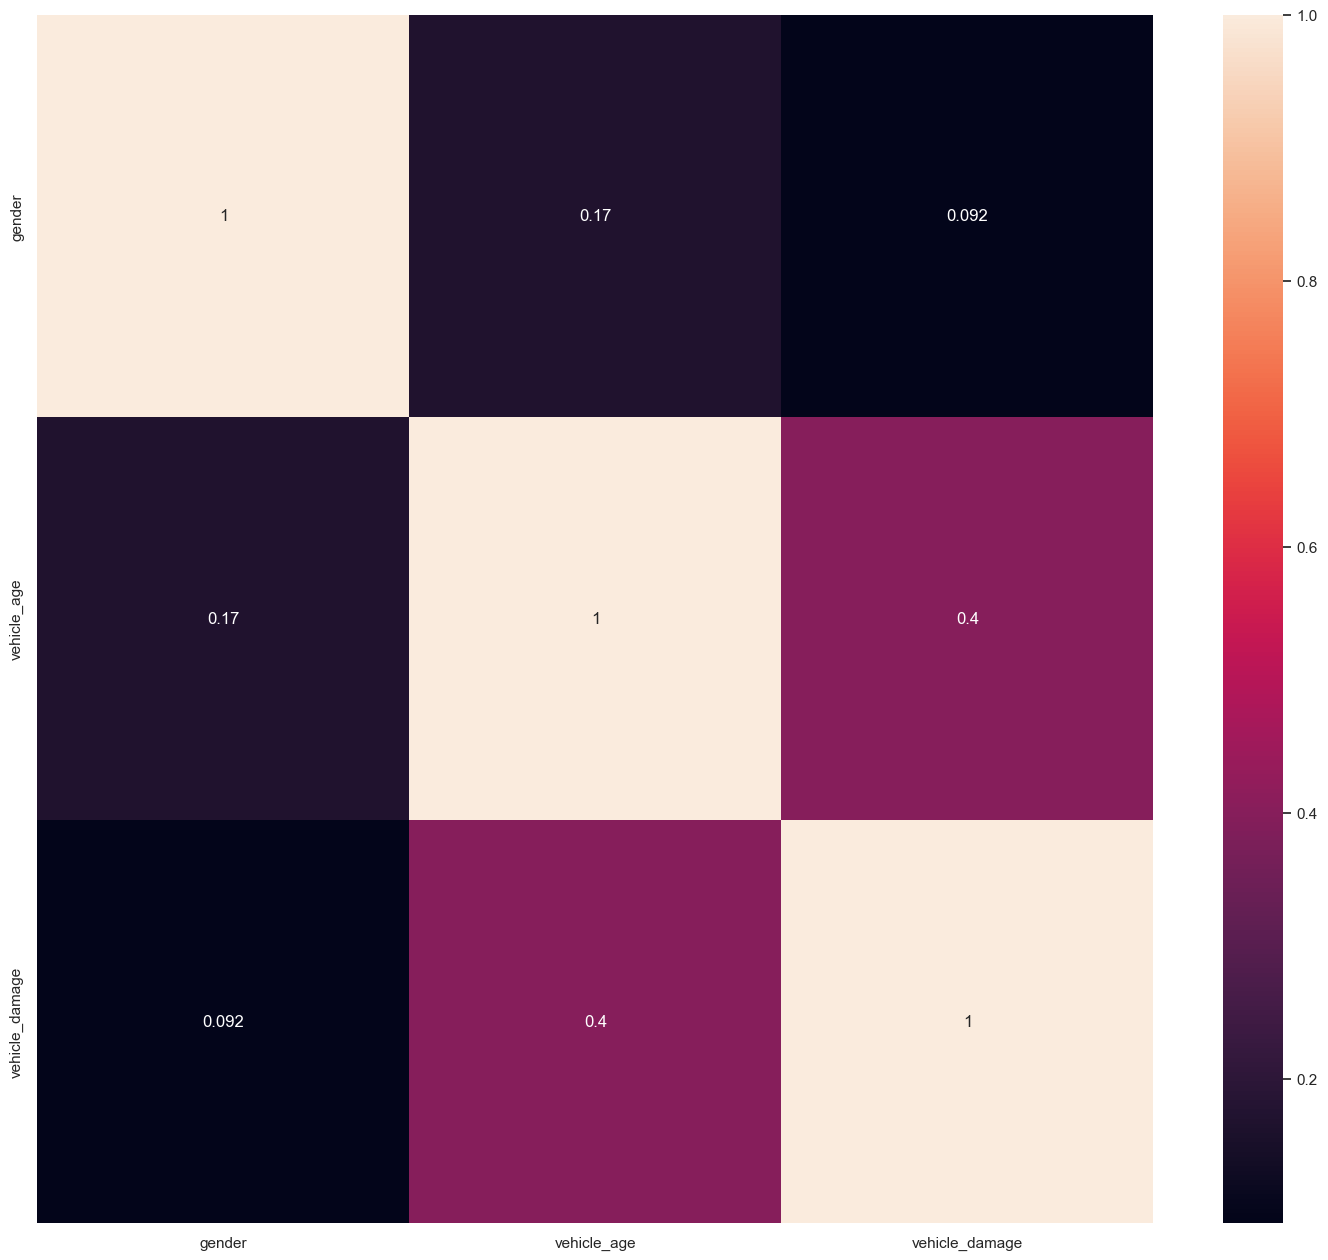

In [34]:
# Calculate cramer V
a1 = cramer_v( df2['gender'], df2['gender'] )
a2 = cramer_v( df2['gender'], df2['vehicle_age'] )
a3 = cramer_v( df2['gender'], df2['vehicle_damage'] )

a4 = cramer_v( df2['vehicle_age'], df2['gender'] )
a5 = cramer_v( df2['vehicle_age'], df2['vehicle_age'] )
a6 = cramer_v( df2['vehicle_age'], df2['vehicle_damage'] )

a7 = cramer_v( df2['vehicle_damage'], df2['gender'] )
a8 = cramer_v( df2['vehicle_damage'], df2['vehicle_age'] )
a9 = cramer_v( df2['vehicle_damage'], df2['vehicle_damage'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3], 
               'vehicle_age': [a4, a5, a6],
               'vehicle_damage': [a7, a8, a9]  })
d = d.set_index( d.columns )



sns.heatmap( d, annot=True)
plt.gcf().set_size_inches(18,16)

# 5.0 DATA PREPARATION

In [77]:
df5=df4.copy()

#make directory to save the serialized transformers
os.makedirs("parameters",exist_ok=True)


## 5.1 Encoding

In [78]:
obj=df5.select_dtypes(include='object').columns
df5[obj].nunique()

gender                    2
region_code              53
vehicle_age               3
vehicle_damage            2
policy_sales_channel    150
dtype: int64

In [81]:
#Ordinal Encoding
oe=OrdinalEncoder()
df5[['vehicle_age','gender','vehicle_damage']]=oe.fit_transform(df5[['vehicle_age','gender','vehicle_damage']])
#pickle.dump(oe,open("parameters/oe_vehicle_age_gender_vehicle_damage.pkl","wb"))
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
215726,215727,1.00000,49,1,41.00000,0,1.00000,1.00000,30123.00000,124.00000,109,0
244933,244934,0.00000,64,1,8.00000,0,1.00000,1.00000,40700.00000,124.00000,241,0
189344,189345,0.00000,24,1,11.00000,1,0.00000,0.00000,2630.00000,152.00000,120,0
232120,232121,0.00000,43,1,17.00000,1,1.00000,0.00000,2630.00000,152.00000,159,0
304224,304225,0.00000,29,1,10.00000,1,0.00000,0.00000,2630.00000,152.00000,117,0


## 5.2 Split dataframe in train and test

In [82]:
#Serialize the dataframe
pickle.dump(df5,open(f'df5.pkl','wb'))
df5=pickle.load(open("df5.pkl",'rb'))

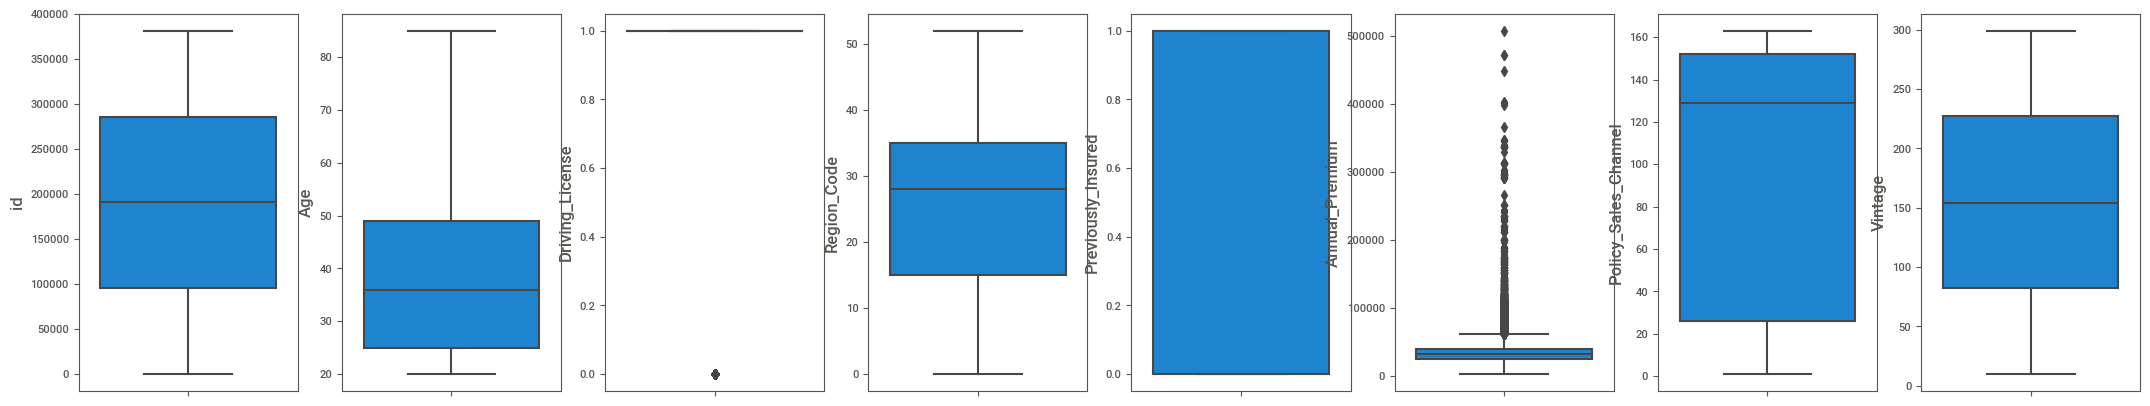

In [83]:
fig = plt.figure(figsize=(30,5))
specs=gridspec.GridSpec(nrows=1, ncols=9, figure=fig)

for n,i in enumerate(Xtrain.select_dtypes(exclude='object').columns):
    ax1= fig.add_subplot(specs[0,n])
    sns.boxplot(y=Xtrain[i],ax=ax1)

## 5.3 Rescaling

In [84]:


#Feature age has an upper and lower boundaries well know. (Hardly you'll find someone with 150 years old or someone with -3 years old). Therefore MinMaxScaler will be used on it.
mms = MinMaxScaler()
df5['age'] = mms.fit_transform( df5[['age']].values )
pickle.dump( mms, open( 'parameters/age_mms_scaler.pkl', 'wb') )


#Feature vintage follows a normal distribution, thus StandardScaler will be used on it.
ss=StandardScaler()
df5['vintage'] = ss.fit_transform( df5[['vintage']].values )
pickle.dump( ss, open( 'parameters/vintage_ss_scaler.pkl', 'wb') )


#Annual premium has a lot of outliers, so RobustScaler will be used on it.
rs = RobustScaler()
df5['annual_premium'] = rs.fit_transform( df5[['annual_premium']].values )
pickle.dump( rs, open( 'parameters/annual_premium_robust_scaler.pkl', 'wb') )


In [85]:
mms=pickle.load(open("parameters/age_mms_scaler.pkl",'rb'))
ss=pickle.load(open("parameters/vintage_ss_scaler.pkl",'rb'))
rs=pickle.load(open("parameters/annual_premium_robust_scaler.pkl",'rb'))

p:\Anaconda3\envs\insurance_cross\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
p:\Anaconda3\envs\insurance_cross\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
p:\Anaconda3\envs\insurance_cross\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

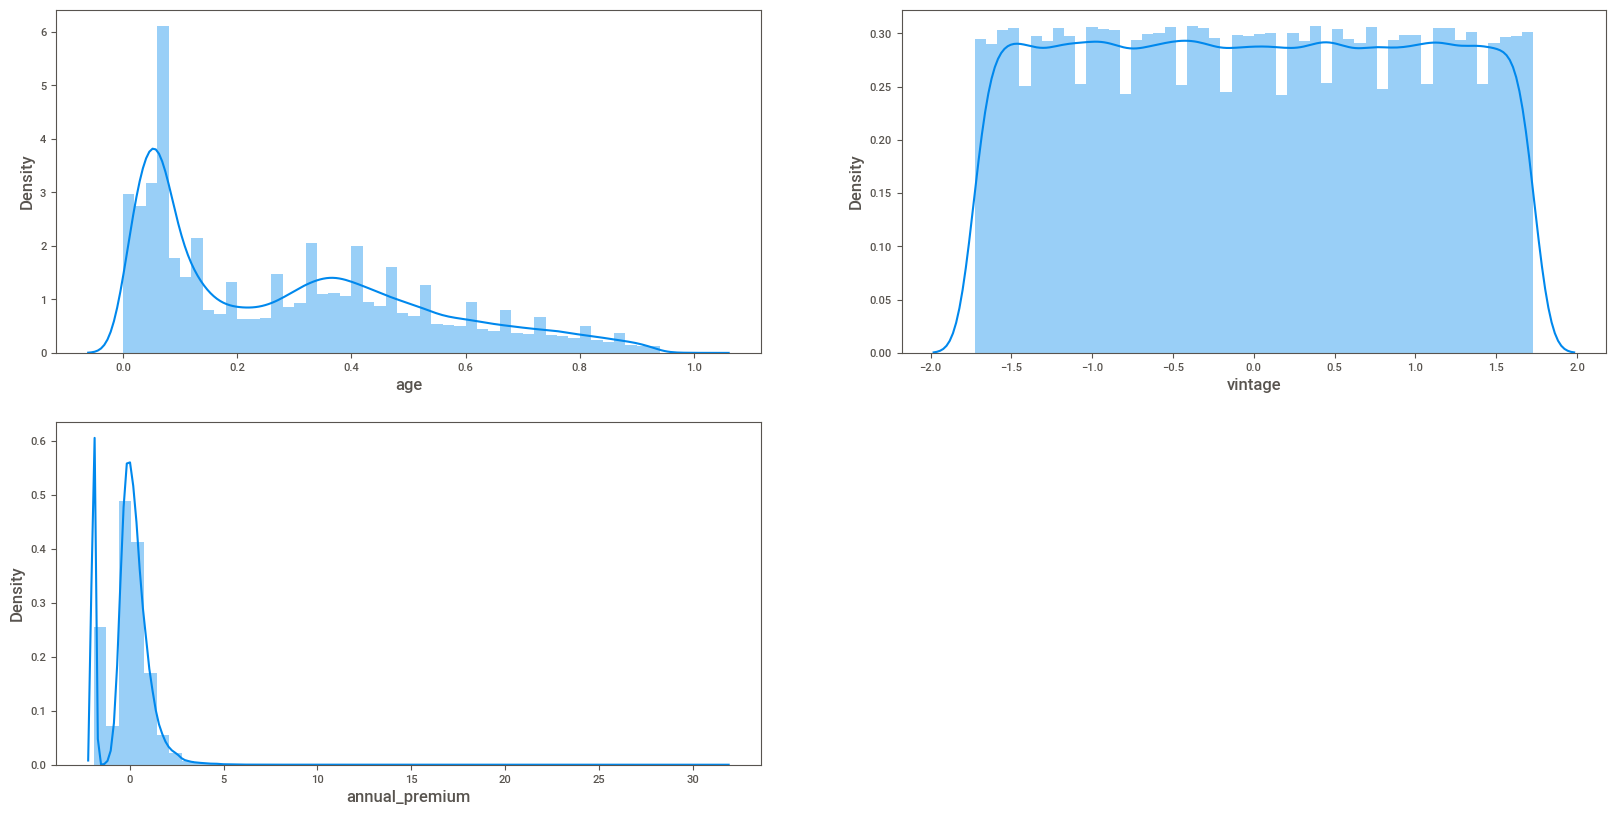

In [87]:
plt.subplot(2,2,1)
sns.distplot(df5['age'])
plt.subplot(2,2,2)
sns.distplot(df5['vintage'])
plt.subplot(2,2,3)
sns.distplot(df5['annual_premium'])

plt.gcf().set_size_inches(20,10)

##  5.4 target variable transformation

In [113]:
#There's no need to rescale binary target variable

# 7.0  FEATURE SELECTION

In [100]:
df6=df5.copy()

In [101]:
Xtest1, ytest1 = Xtest0.copy(), ytest.copy()

## 7.2 Boruta as Feature Selector

In [102]:
### transform train and test set to numpy array to increase performance
Xtrain2_v, ytrain_v = Xtrain2.values, ytrain.values.ravel()
pipe=pipe_insurance()
Xtest2=pipe.data_cleaning(Xtest1)
Xtest2.head(2)


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
192149,192150,Female,38,1,7.00000,0,1. 1_2_years,Yes,37344.00000,26.00000,76
189829,189830,Male,51,1,36.00000,0,1. 1_2_years,No,2630.00000,156.00000,264


In [103]:
Xtest3=pipe.data_preparation(Xtest2)
Xtest3.head(2)

ValueError: Found unknown categories ['0. 1_less_years', '1. 1_2_years', '2. 2_more_years'] in column 0 during transform

In [ ]:


Xtest_v, ytest_v = Xtest.drop(['date'],axis=1), ytest.values.ravel()


rf = RandomForestRegressor( n_jobs=-1)

boruta = BorutaPy(rf , n_estimators='auto', verbose=2, random_state=42).fit(Xtrain2_v,ytrain_v)

cols_selected = boruta.support_.tolist()



cols_selected = boruta.support_.tolist()

## to read the columns chosen by Boruta instead of numbers we need to run the lines below
## as x_train still has the 'date' and 'sales' features, We need to remove them to preserve the same column sequence as x_train_v
x_train_fs = x_train.drop(['date','sales'],axis=1)

## the line below selects, based on the variable cols_selected, taken from the 'support_' output of Boruta, which is a vector of True and False for each of the columns
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

## columns not selected
cols_vnt_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## 7.3 Manual Feature Selection

In [ ]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']
len(cols_selected_boruta)

20

In [ ]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 8.0 MACHINE LEARNING MODELLING

In [ ]:
xtrain=train[cols_selected_boruta]
xtest=test[cols_selected_boruta]
xtrainfull=train[cols_selected_boruta_full]

## 8.1 Average Model

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)


aux1 = xtest.copy()
aux1['sales'] = ytest.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
ypred_baseline = aux1['predictions']

# performance
baseline_result = errors_ml(aux1['sales'],ypred_baseline,model_name='average_model')
baseline_result

,model_name,mae,mape,mse,rmse
0,average_model,1354.80035,0.20640,3367722.45872,1835.13554


## 8.2 Linear Regression Model

In [ ]:
# model
lr = LinearRegression().fit( xtrain, ytrain )

# prediction
ypred_lr = lr.predict( xtest )

# performance
lr_result = errors_ml(ytest, ypred_lr,model_name=lr.__class__.__name__)
lr_result

,model_name,mae,mape,mse,rmse
0,LinearRegression,1867.08977,0.29269,7134503.90969,2671.04922


## 8.3 Linear Regression Model - Cross Validation

In [ ]:
# model
lrr = Lasso( alpha=0.01 ).fit( xtrain, ytrain )

# prediction
ypred_lrr = lrr.predict( xtest )

# performance
lrr_result = errors_ml(ytest, ypred_lrr,model_name=lrr.__class__.__name__)
lrr_result

,model_name,mae,mape,mse,rmse
0,Lasso,1891.70488,0.28911,7532015.33699,2744.45174


## 8.4 Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor(n_estimators=15, n_jobs=-1,  max_depth=25, random_state=42).fit( xtrain, ytrain )

# prediction
ypred_rf = rf.predict( xtest )

# performance
rf_result = errors_ml(ytest, ypred_rf,model_name=rf.__class__.__name__)
rf_result

,model_name,mae,mape,mse,rmse
0,RandomForestRegressor,733.13469,0.10679,1194321.76834,1092.85030


## 8.5 XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor(colsample_bytree=0.6,gamma=0.3,learning_rate=0.1,max_depth=15,
min_child_weight=3,subsample=0.9,n_estimators=50,eval_metric='rmse',early_stopping_rounds=20,random_state=42).fit( xtrain, ytrain )

# prediction
ypred_xgb = model_xgb.predict( xtest )
# performance
xgb_result = errors_ml(ytest, ypred_xgb,model_name=model_xgb.__class__.__name__)
xgb_result

[05:11:08] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,model_name,mae,mape,mse,rmse
0,XGBRegressor,940.36205,0.12634,1981111.28621,1407.51955


## 8.6 Compare Models Performance

In [ ]:
modelling_result=pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values("rmse")

,model_name,mae,mape,mse,rmse
0,RandomForestRegressor,733.13469,0.10679,1194321.76834,1092.85030
0,XGBRegressor,940.36205,0.12634,1981111.28621,1407.51955
0,average_model,1354.80035,0.20640,3367722.45872,1835.13554
0,LinearRegression,1867.08977,0.29269,7134503.90969,2671.04922
0,Lasso,1891.70488,0.28911,7532015.33699,2744.45174


## 8.7 Cross Validation

In [ ]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    print(f'training {model_name}')
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = errors_ml( yvalidation, yhat, model_name=model_name)




        # store performance of each kfold iteration
        mae_list.append(  m_result['mae'] )
        mape_list.append( m_result['mape'] )
        rmse_list.append( m_result['rmse'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

# 8.0 HYPERPARAMETER TUNING

In [ ]:
params = {"colsample_bytree":[ 0.7, 0.9],
"learning_rate": [0.1],
"max_depth":[10,15,20],
"min_child_weight":[2,3,4], 
"subsample": [ 0.7,0.9],
"gamma": [0.3,0.4],
"n_estimators":[50,75],
"eval_metric":['rmse'],
"early_stopping_rounds":[20],
"random_state":[42]}

## 8.1 Final Model

In [ ]:
param_tuned = {
'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 4,
 'subsample': 0.7, 'gamma': 0.3, 'n_estimators': 100, 'eval_metric': 'rmse',
 # 'early_stopping_rounds': 20,
  'random_state': 42
        }

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eval_metric=param_tuned['eval_metric'],
                                    learning_rate=param_tuned['learning_rate'],
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'],
                                    random_state=param_tuned['random_state'],
                                    gamma=param_tuned['gamma']).fit( xtrain, ytrain )

# prediction
ypred_xgb_tuned = model_xgb_tuned.predict(xtest)

# performance
xgb_result_tuned = errors_ml(ytrue=ytest,ypred=ypred_xgb_tuned,model_name=model_xgb_tuned.__class__.__name__)
xgb_result_tuned

[06:29:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,model_name,mae,mape,mse,rmse
0,XGBRegressor,860.14753,0.12522,1606809.99428,1267.60009


In [ ]:
def mean_percentage_error (y, ypred):
    return np.mean((y - ypred)/y )

In [ ]:
mpe = mean_absolute_percentage_error( np.expm1 (ytest), np.expm1(ypred_xgb_tuned))
mpe

NameError: name 'ytest' is not defined

# 9.0 ERROR INTERPRETATION TO BUSINESS

In [ ]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

In [ ]:
df9 = test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1( df9['sales'])
df9['predictions']= np.expm1(ypred_xgb_tuned)
df9.head(1)

NameError: name 'cols_selected_boruta_full' is not defined

## 9.1 business performance

In [ ]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

<AxesSubplot:xlabel='store', ylabel='MAPE'>

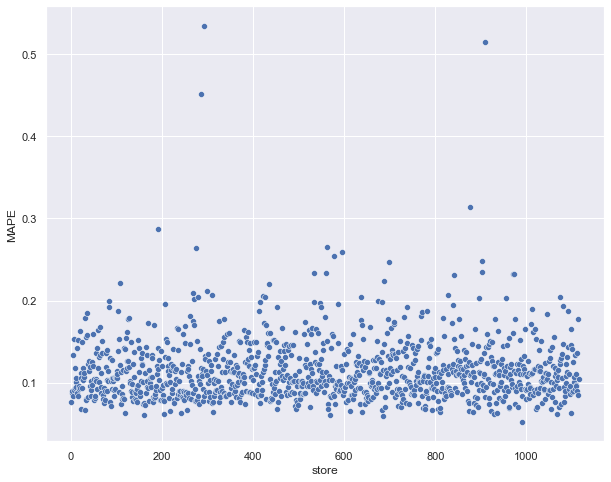

In [ ]:
sns.scatterplot(x='store',y='MAPE',data=df92)

In [ ]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,102837.30469,99522.55777,106152.05160,3314.74692,0.53418
908,909,208463.70312,200388.53460,216538.87165,8075.16852,0.51542
285,286,189815.26562,188372.88003,191257.65122,1442.38559,0.45154
875,876,180474.18750,176157.09301,184791.28199,4317.09449,0.31389
191,192,342641.09375,338712.52832,346569.65918,3928.56543,0.28691


## 9.2 total performance

In [ ]:
df93=df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})
df93['Values']=df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$267,868,336.00"
1,worst_scenario,"R$266,907,597.52"
2,best_scenario,"R$268,829,090.00"


## 9.3 machine learning performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

NameError: name 'df9' is not defined

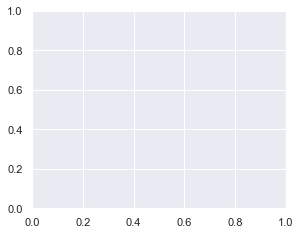

In [ ]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0 DEPLOY MODEL TO PRODUCTION

## 10.1 Rossmann class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='P:\Python\GitHub\forecast_sales'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + '\parameters\competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + '\parameters\competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + '\parameters\promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + '\parameters\year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + '\parameters\store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

      
        #fillna competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        # change data type competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # change data type promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

     
        # row filtering
        df2 = df2[df2['open'] != 0]

        # col filtering
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API handler

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann import rossmann
import inflection

# loading model
model = pickle.load( open(r'P:\\Python\\GitHub\\forecast_sales\\model_xgb_rossmann_v0.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API tester

In [ ]:
#loading test dataset
df10=pd.read_csv(r"data/test.csv")
df10.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.00000,1,0,0
1,2,3,4,2015-09-17,1.00000,1,0,0
2,3,7,4,2015-09-17,1.00000,1,0,0
3,4,8,4,2015-09-17,1.00000,1,0,0
4,5,9,4,2015-09-17,1.00000,1,0,0


In [ ]:
# merge test dataset +store
df_test=df10.merge(store,how='left',on='Store')

#choose store for prediction
df_test = df_test[df_test['Store'] == 22]

#remove closed days
df_test=df_test[(df_test['Open']!=0) & (~df_test['Open'].isnull())]


In [ ]:
df_test.head(1)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
15,16,22,4,2015-09-17,1.00000,1,0,0,a,a,1040.00000,NaN,NaN,1,22.00000,2012.00000,"Jan,Apr,Jul,Oct"


In [ ]:
len(df_test.columns)

17

In [ ]:
# convert Dataframe to json
import json
import requests
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
#API Call
url = 'http://192.168.1.10:5000/rossmann/predict'
#url = 'https://rossman-model-kos.herokuapp.com/rossmann/rossmann/predict'
data=data

header = {'Content-type':  'application/json','debug':'True'}

r=requests.post(url, data, headers=header)
print( f'Status Code {r.status_code}')

Status Code 503


In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())

In [ ]:
d1.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,prediction
0,16,22,4,2015-09-17,1.0,1,0,0,a,a,1040.0,None,None,1,22.0,2012.0,"Jan,Apr,Jul,Oct",4674.521973
1,872,22,3,2015-09-16,1.0,1,0,0,a,a,1040.0,None,None,1,22.0,2012.0,"Jan,Apr,Jul,Oct",4385.039062
2,1728,22,2,2015-09-15,1.0,1,0,0,a,a,1040.0,None,None,1,22.0,2012.0,"Jan,Apr,Jul,Oct",5403.807617
3,2584,22,1,2015-09-14,1.0,1,0,1,a,a,1040.0,None,None,1,22.0,2012.0,"Jan,Apr,Jul,Oct",6495.707520
4,4296,22,6,2015-09-12,1.0,0,0,0,a,a,1040.0,None,None,1,22.0,2012.0,"Jan,Apr,Jul,Oct",3049.921875


In [ ]:
d2 = d1[['Store', 'prediction']].groupby( 'Store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'Store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 22 will sell R$174,469.19 in the next 6 weeks


# CLASS PREDICTOR

In [49]:
import pickle
import pandas as pd
import numpy as np
import math, datetime

class pipe_insurance( object ):
    def __init__( self ):
        self.home_path='P:\Python\GitHub\insurance_cross'
        self.oe = pickle.load( open( self.home_path + r'\parameters\oe_vehicle_age_gender_vehicle_damage.pkl', 'rb') )
        self.mss = pickle.load( open( self.home_path + r'\parameters\age_mms_scaler.pkl', 'rb') )
        self.ss = pickle.load( open( self.home_path + r'\parameters\annual_premium_robust_scaler.pkl', 'rb') )
        self.rs = pickle.load( open( self.home_path + r'\parameters\vintage_ss_scaler.pkl', 'rb') )

        
    def data_cleaning( self, df1 ): 
        
        df1.columns=df1.columns.str.lower()

        for i in ['region_code','policy_sales_channel']:
                df1[i]=df1[i].astype('object')

        df1['vehicle_age']=df1['vehicle_age'].map({'> 2 Years':'2. 2_more_years','1-2 Year':'1. 1_2_years', '< 1 Year': '0. 1_less_years'})

        return df1

    def feature_engineering( self, df2):
        return df2

        
    def data_preparation( self, df3 ):
        df3[['vehicle_age','gender','vehicle_damage']]=oe.transform(df3[['vehicle_age','gender','vehicle_damage']])
        df3['age'] = mms.transform( df3[['age']].values )
        df3['vintage'] = ss.transform( df3[['vintage']].values )
        df3['annual_premium'] = rs.transform( df3[['annual_premium']].values )

        return df3
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )



